In [ ]:
from cProfile import label

# class that inherits from property based test
import numpy as np
import csv
import pandas as pd
from scipy.special import xlogy

pd.options.display.width = 240
import seaborn as sns
import scipy
import os
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import ylabel, xlabel
from numpy.f2py.cb_rules import cb_map
from qiskit import QuantumCircuit
from sympy.printing.pretty.pretty_symbology import line_width

# RQ1: Impact of test suite thoroughness on effectiveness
In this we have a set of heatmaps showing mutation score vs various independent variables.

In [3]:
def read_merged_data_to_dataframe(algorithm_name):
    # Define the directory where the CSV files are stored
    filename = f"mutation_test_results/{algorithm_name}/{algorithm_name}_merged_results.csv"
    return pd.read_csv(filename)

def remove_exp2(df):
    return df[~df["Number of Measurements"].isin([4200, 2500])]

def clean(dfs_list):
    for df in dfs_list:
        df["Equivalent"] = df['Mutant Name'].str.contains('_em')
        df["Algorithm"] = df["Mutant Name"].apply(lambda s: s.rsplit("_", 1)[0])
        df = df.groupby(["Number of Measurements", "Number of Inputs", "Number of Properties", "Equivalent", "Algorithm"])['Result'].apply(lambda x: (x == 'Fail').sum() / (10.0 if x.name[3] else 20.0)).reset_index(name='Result')
        return df


In [4]:
all_df = []
all_df_c = []

qt_df = read_merged_data_to_dataframe("quantum_teleportation")
qt_df = remove_exp2(qt_df)
dj_df = read_merged_data_to_dataframe("deutsch_jozsa")
dj_df = remove_exp2(dj_df)
qft_df = read_merged_data_to_dataframe("quantum_fourier_transform")
qft_df = remove_exp2(qft_df)
qpe_df = read_merged_data_to_dataframe("quantum_phase_estimation")
qpe_df = remove_exp2(qpe_df)
grover_df = read_merged_data_to_dataframe("grovers_algorithm")
grover_df = remove_exp2(grover_df)

all_df = [qt_df, dj_df, qft_df, qpe_df, grover_df]
all_df = pd.concat(all_df)

qt_df_c = clean([qt_df])
dj_df_c = clean([dj_df])
qft_df_c = clean([qft_df])
qpe_df_c = clean([qpe_df])
grover_df_c = clean([grover_df])
all_df_c = clean([all_df])

all_df

,Mutant Name,Number of Properties,Number of Inputs,Number of Measurements,Result,Number of Circuits Executed,Number of Unique Failed Properties,Number of Failed Properties,Unique Failed Properties,Time Taken,Equivalent,Algorithm
120,quantum_teleportation_em0,1,16,100,Pass,96,0,0,NaN,0.371,True,quantum_teleportation
121,quantum_teleportation_em1,1,16,100,Pass,96,0,0,NaN,0.312,True,quantum_teleportation
122,quantum_teleportation_em2,1,16,100,Pass,96,0,0,NaN,0.343,True,quantum_teleportation
123,quantum_teleportation_em3,1,16,100,Pass,96,0,0,NaN,0.509,True,quantum_teleportation
124,quantum_teleportation_em4,1,16,100,Pass,96,0,0,NaN,0.521,True,quantum_teleportation
...,...,...,...,...,...,...,...,...,...,...,...,...
5785,grovers_algorithm_m5,3,8,800,Fail,35,2,12,GroversAlgorithmMostFrequentMarked & GroversAl...,13.878,False,grovers_algorithm
5786,grovers_algorithm_m6,3,8,800,Fail,35,2,14,GroversAlgorithmMostFrequentMarked & GroversAl...,12.706,False,grovers_algorithm
5787,grovers_algorithm_m7,3,8,800,Fail,35,3,21,GroversAlgorithmLowerRegisterMinus & GroversAl...,8.707,False,grovers_algorithm
5788,grovers_algorithm_m8,3,8,800,Fail,35,2,13,GroversAlgorithmMostFrequentMarked & GroversAl...,17.143,False,grovers_algorithm


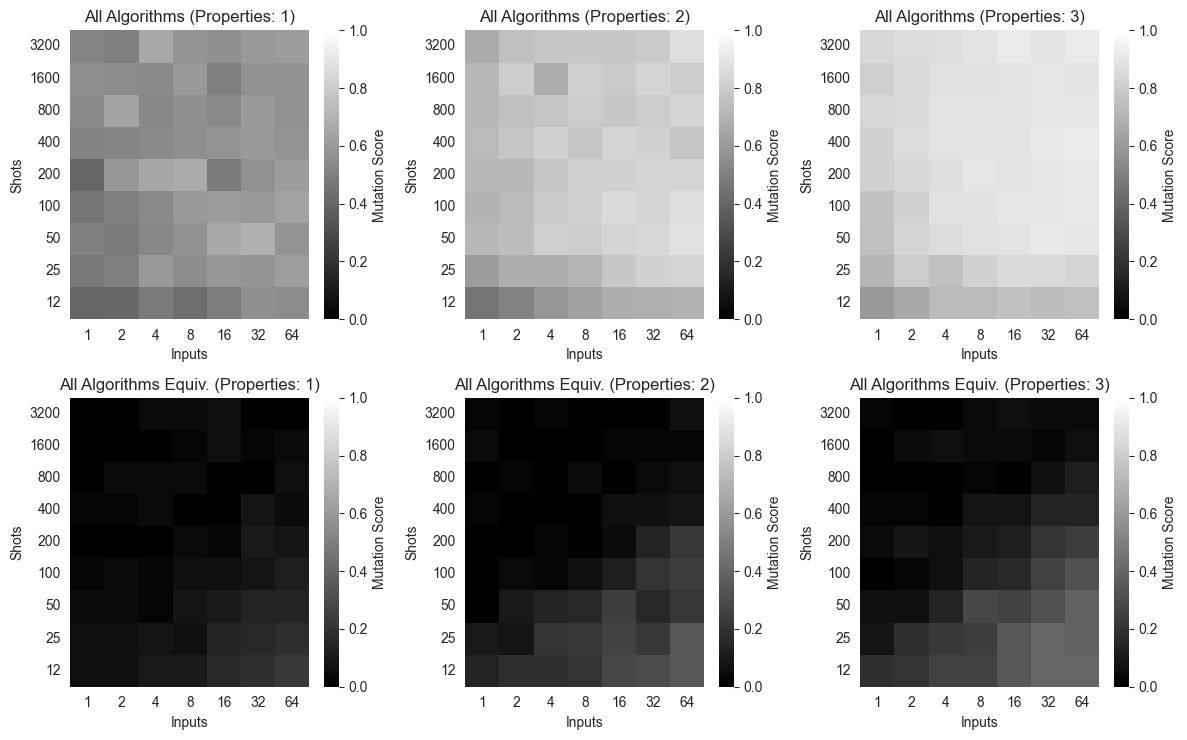

In [5]:
def plot_failures(df, algorithm_name, dp_format=".1f"):
    df_non_equivalent = df[df['Mutant Name'].str.contains('_m')]
    df_equivalent = df[df['Mutant Name'].str.contains('_em')]

    # Create a figure with 2 rows and 3 columns
    fig, axes = plt.subplots(2, 3, figsize=(12, 7.5), sharey=False)

    # viridis or magma
    palette = sns.color_palette("gray", as_cmap=True)

    # Plot heatmaps for non-equivalent mutants
    for i, num_properties in enumerate([1, 2, 3]):
        df_subset = df_non_equivalent[df_non_equivalent['Number of Properties'] == num_properties]
        failure_rate = df_subset.groupby(["Number of Measurements", "Number of Inputs"])['Result'].apply(lambda x: (x == 'Fail').sum()).unstack()

        grouped = df_subset.groupby(["Number of Measurements", "Number of Inputs"])
        result = grouped['Mutant Name'].nunique().reset_index()
        max_value = result['Mutant Name'].iloc[0]

        failure_rate = failure_rate / max_value

        sns.heatmap(failure_rate, annot=False, cmap=palette, ax=axes[0, i], fmt=dp_format,
                    linewidth=0, vmin=0, vmax=1, cbar_kws={'label': 'Mutation Score'},
                    annot_kws={"size": 10})
        axes[0, i].set_title(f'{algorithm_name} (Properties: {num_properties})')
        axes[0, i].set_xlabel('Inputs')
        axes[0, i].set_ylabel('Shots')
        axes[0, i].invert_yaxis()

    # Plot heatmaps for equivalent mutants
    for i, num_properties in enumerate([1, 2, 3]):
        df_subset = df_equivalent[df_equivalent['Number of Properties'] == num_properties]
        pass_rate = df_subset.groupby(["Number of Measurements", "Number of Inputs"])['Result'].apply(lambda x: (x == 'Fail').sum()).unstack()

        grouped = df_subset.groupby(["Number of Measurements", "Number of Inputs"])
        result = grouped['Mutant Name'].nunique().reset_index()
        max_value = result['Mutant Name'].iloc[0]

        pass_rate = pass_rate / max_value

        sns.heatmap(pass_rate, annot=False, cmap=palette, ax=axes[1, i], fmt=dp_format,
                    linewidth=0, vmin=0, vmax=1, cbar_kws={'label': 'Mutation Score'},
                    annot_kws={"size": 10})
        axes[1, i].set_title(f'{algorithm_name} Equiv. (Properties: {num_properties})')
        axes[1, i].set_xlabel('Inputs')
        axes[1, i].set_ylabel('Shots')
        axes[1, i].invert_yaxis()

    plt.tight_layout()
    plt.savefig(f"{algorithm_name.replace(' ', '_')}_failures_heatmap.png", dpi=300, bbox_inches='tight')
    plt.show()
    # plt.close()

plot_failures(all_df, "All Algorithms", dp_format=".2f")

# RQ1.1: Effect of Property Count per Program

In [6]:
# get the standard deviation of data for all algorithms from 1-3 properties and 50-3200 measurements, and 1-64 inputs
def get_stats(df, group_by="Number of Properties", filter_by_feature=None, filter_by_values=None, feature_str="Result"):
    failure_rate = df[df['Equivalent'] == False]
    pass_rate = df[df['Equivalent'] == True]

    if filter_by_feature is not None:
        for i in range(len(filter_by_feature)):
            failure_rate = failure_rate[failure_rate[filter_by_feature[i]].isin(filter_by_values[i])]
            pass_rate = pass_rate[pass_rate[filter_by_feature[i]].isin(filter_by_values[i])]

    print("Not Equivalent")

    if group_by is not None:
        print("STD NE")
        print(failure_rate.groupby(group_by)[feature_str].std())
        print("Median NE")
        print(failure_rate.groupby(group_by)[feature_str].median())
        print("Mean NE")
        print(failure_rate.groupby(group_by)[feature_str].mean())
        print("Pearson Correlation Coefficient NE")
        print(scipy.stats.spearmanr(failure_rate[group_by], failure_rate[feature_str], alternative='two-sided'))
    else:
        if feature_str == "Time Taken":
            print(failure_rate[['Algorithm', feature_str, "Result"]])
        else:
            print("STD NE")
            print(failure_rate[feature_str].std())
            print("Median NE")
            print(failure_rate[feature_str].median())
            print("Mean NE")
            print(failure_rate[feature_str].mean())

    print("Equivalent")

    if group_by is not None:
        print("STD E")
        print(pass_rate.groupby(group_by)[feature_str].std())
        print("Median E")
        print(pass_rate.groupby(group_by)[feature_str].median())
        print("Mean E")
        print(pass_rate.groupby(group_by)[feature_str].mean())
        print("Pearson Correlation Coefficient E")
        print(scipy.stats.spearmanr(pass_rate[group_by], pass_rate[feature_str], alternative='two-sided'))
    else:
        if feature_str == "Time Taken":
            print(pass_rate[['Algorithm', feature_str, "Result"]])
        else:
            print("STD E")
            print(pass_rate[feature_str].std())
            print("Median E")
            print(pass_rate[feature_str].median())
            print("Mean E")
            print(pass_rate[feature_str].mean())

Not Equivalent
STD NE
Number of Properties
1    0.195229
2    0.164830
3    0.144081
Name: Result, dtype: float64
Median NE
Number of Properties
1    0.55
2    0.80
3    0.85
Name: Result, dtype: float64
Mean NE
Number of Properties
1    0.554762
2    0.760000
3    0.847778
Name: Result, dtype: float64
Pearson Correlation Coefficient NE
SignificanceResult(statistic=0.5785167787057532, pvalue=1.6208778766729958e-85)
Equivalent
STD E
Number of Properties
1    0.115362
2    0.205150
3    0.275462
Name: Result, dtype: float64
Median E
Number of Properties
1    0.0
2    0.0
3    0.0
Name: Result, dtype: float64
Mean E
Number of Properties
1    0.055238
2    0.091111
3    0.132063
Name: Result, dtype: float64
Pearson Correlation Coefficient E
SignificanceResult(statistic=0.07791654841673205, pvalue=0.016588945008228658)


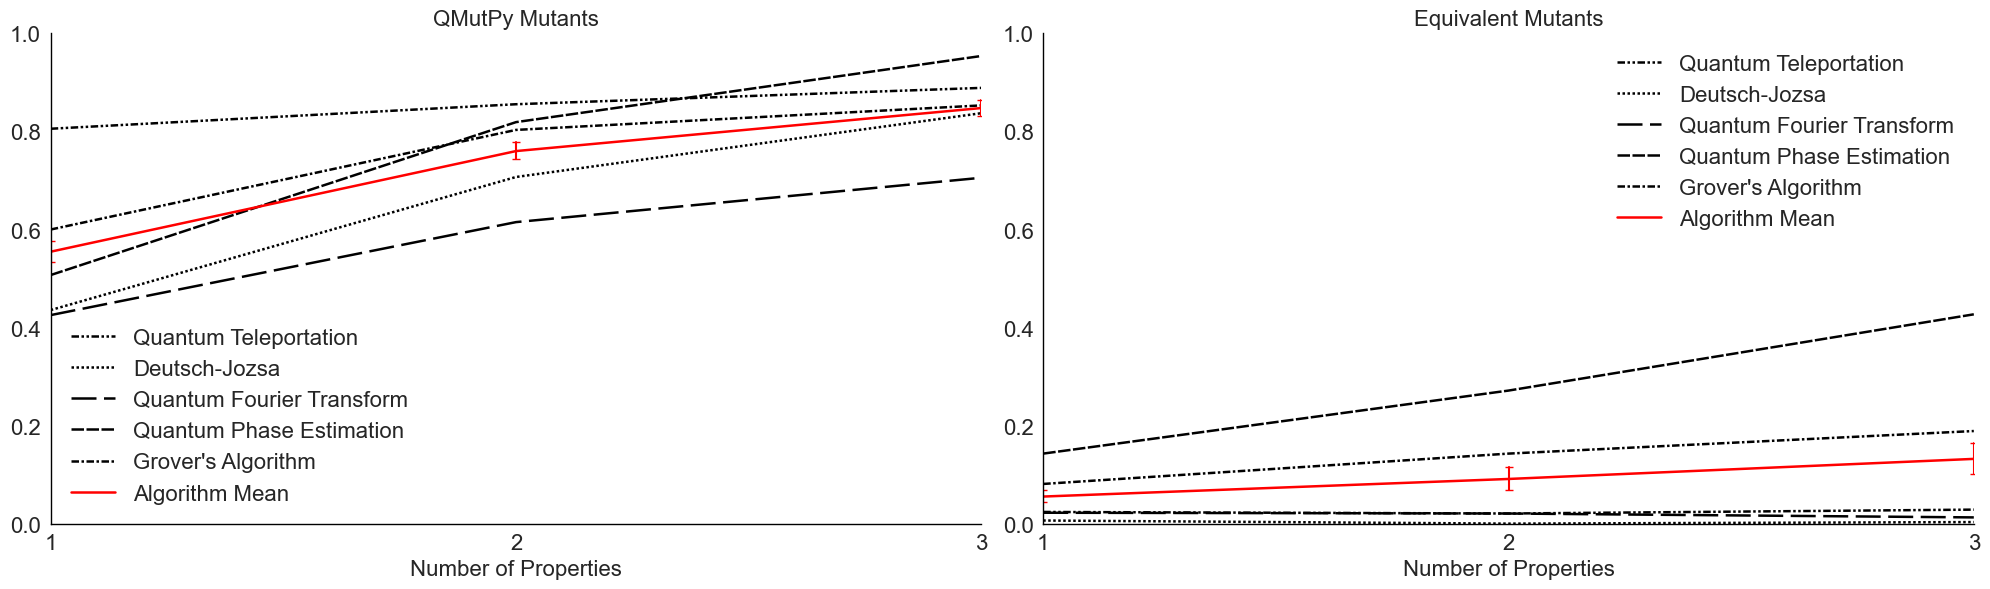

In [7]:
def plot_linegraph(dfs, dfs_names, feature_str, log_scale=False, cleaned_data=None, filter_by_feature=None, filter_by_values=None):
    # Create a figure with 2 rows and 3 columns
    dash_styles = [
        (3, 1, 1, 1, 1, 1),       # solid line
        (1, 1),             # dashed line
        (10, 3),      # dash-dot line
        (5, 1),             # dotted line
        (3, 1, 1, 1)      # dash-dot-dot line
    ]

    fig, ((ax1), (ax2)) = plt.subplots(1, 2, figsize=(20, 6))
    ax1.set_ylim(0, 1)
    ax2.set_ylim(0, 1)

    ax1.grid(False)
    ax2.grid(False)

    ax1.title.set_text(f'QMutPy Mutants')
    ax1.title.set_fontsize(16)
    ax2.title.set_text(f'Equivalent Mutants')
    ax2.title.set_fontsize(16)

    if log_scale:
        ax1.set_xscale('log')
        ax2.set_xscale('log')

    if feature_str == "Number of Measurements":
        ticks = [12, 25, 50, 100, 200, 400, 800, 1600, 3200]
    elif feature_str == "Number of Inputs":
        ticks = [1, 2, 4, 8, 16, 32, 64]
    elif feature_str == "Number of Properties":
        ticks = [1, 2, 3]

    ax1.set_xlim(ticks[0], ticks[-1])
    ax1.set_xticks(ticks)
    ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax1.minorticks_off()

    ax2.set_xlim(ticks[0], ticks[-1])
    ax2.set_xticks(ticks)
    ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax2.minorticks_off()

    idx = 0
    for algorithm_df, algorithm_name in zip(dfs, dfs_names):
        df_non_equivalent = algorithm_df[algorithm_df['Mutant Name'].str.contains('_m')]
        df_equivalent = algorithm_df[algorithm_df['Mutant Name'].str.contains('_em')]

        # apply filters
        if filter_by_feature is not None:
            for i in range(len(filter_by_feature)):
                df_non_equivalent = df_non_equivalent[df_non_equivalent[filter_by_feature[i]].isin(filter_by_values[i])]
                df_equivalent = df_equivalent[df_equivalent[filter_by_feature[i]].isin(filter_by_values[i])]

        df_non_equivalent = df_non_equivalent.groupby(["Number of Measurements", "Number of Inputs", "Number of Properties"])['Result'].apply(lambda x: (x == 'Fail').sum()).reset_index(name='Result')
        failure_rate = df_non_equivalent.groupby(feature_str)['Result'].mean().reset_index(name='Result')
        failure_rate['Result'] = failure_rate['Result']/20.0
        sns.lineplot(ax=ax1, data=failure_rate, x=feature_str, y="Result", errorbar=None, err_style="bars", err_kws={'capsize':10}, label=algorithm_name, linewidth=1.8, color="black", dashes=dash_styles[idx])

        df_equivalent = df_equivalent.groupby(["Number of Measurements", "Number of Inputs", "Number of Properties"])['Result'].apply(lambda x: (x == 'Fail').sum()).reset_index(name='Result')
        pass_rate = df_equivalent.groupby(feature_str)['Result'].mean().reset_index(name='Result')
        pass_rate['Result'] = pass_rate['Result']/10.0
        sns.lineplot(ax=ax2, data=pass_rate, x=feature_str, y="Result", errorbar=None, err_style="bars", err_kws={'capsize':10}, label=algorithm_name,linewidth=1.8, color="black", dashes=dash_styles[idx])
        idx += 1

    if cleaned_data is not None:
        failure_rate = cleaned_data[cleaned_data['Equivalent'] == False]
        pass_rate = cleaned_data[cleaned_data['Equivalent'] == True]

        if filter_by_feature is not None:
            for i in range(len(filter_by_feature)):
                failure_rate = failure_rate[failure_rate[filter_by_feature[i]].isin(filter_by_values[i])]
                pass_rate = pass_rate[pass_rate[filter_by_feature[i]].isin(filter_by_values[i])]

        sns.lineplot(ax=ax1, data=failure_rate, x=feature_str, y="Result", label="Algorithm Mean", color="red", errorbar="ci", err_style="bars", err_kws={'capsize':3}, linewidth=1.8)

        sns.lineplot(ax=ax2, data=pass_rate, x=feature_str, y="Result", label="Algorithm Mean", color="red", errorbar="ci", err_style="bars", err_kws={'capsize':3}, linewidth=1.8)


    ax1.set(ylabel=None)
    ax1.xaxis.label.set_size(16)
    ax2.xaxis.label.set_size(16)
    for item in ax1.get_xticklabels() + ax2.get_xticklabels() + ax1.get_yticklabels() + ax2.get_yticklabels():
        item.set_fontsize(16)
    ax1.spines['left'].set_linewidth(1)
    ax1.spines['left'].set_color('black')
    ax1.spines['bottom'].set_linewidth(1)
    ax1.spines['bottom'].set_color('black')
    ax1.axvline(color='k', linewidth=1)
    ax2.set(ylabel=None)
    ax2.spines['left'].set_linewidth(1)
    ax2.spines['left'].set_color('black')
    ax2.spines['bottom'].set_linewidth(1)
    ax2.spines['bottom'].set_color('black')
    ax1.legend(frameon=False, fontsize=16)
    ax2.legend(frameon=False, fontsize=16)
    sns.despine()

    plt.tight_layout()
    if filter_by_feature is not None:
        plt.savefig(f"{feature_str.replace(' ', '_')}_{filter_by_feature[0].replace(' ', '_')}_failures_line.svg", dpi=100, bbox_inches='tight')
        # plt.savefig(f"{feature_str.replace(' ', '_')}_{filter_by_feature[0].replace(' ', '_')}_failures_line.png", dpi=300, bbox_inches='tight')
    else:
        plt.savefig(f"{feature_str.replace(' ', '_')}_failures_line.svg", dpi=100, bbox_inches='tight')
        # plt.savefig(f"{feature_str.replace(' ', '_')}_failures_line.png", dpi=100, bbox_inches='tight')
    plt.show()
    # plt.close()

dfs = [qt_df, dj_df, qft_df, qpe_df, grover_df]
dfs_names = ["Quantum Teleportation", "Deutsch-Jozsa", "Quantum Fourier Transform", "Quantum Phase Estimation", "Grover's Algorithm"]


get_stats(all_df_c, group_by="Number of Properties")
plot_linegraph(dfs, dfs_names, "Number of Properties", log_scale=False, cleaned_data=all_df_c)

# Varying properties, (1600, 3200) measurements

Not Equivalent
STD NE
Number of Properties
1    0.190260
2    0.119402
3    0.067906
Name: Result, dtype: float64
Median NE
Number of Properties
1    0.550
2    0.775
3    0.850
Name: Result, dtype: float64
Mean NE
Number of Properties
1    0.565714
2    0.774286
3    0.877857
Name: Result, dtype: float64
Pearson Correlation Coefficient NE
SignificanceResult(statistic=0.643369806141632, pvalue=6.283473512744052e-26)
Equivalent
STD E
Number of Properties
1    0.046935
2    0.042684
3    0.055746
Name: Result, dtype: float64
Median E
Number of Properties
1    0.0
2    0.0
3    0.0
Name: Result, dtype: float64
Mean E
Number of Properties
1    0.020000
2    0.014286
3    0.032857
Name: Result, dtype: float64
Pearson Correlation Coefficient E
SignificanceResult(statistic=0.1173071966384455, pvalue=0.0899511140230345)


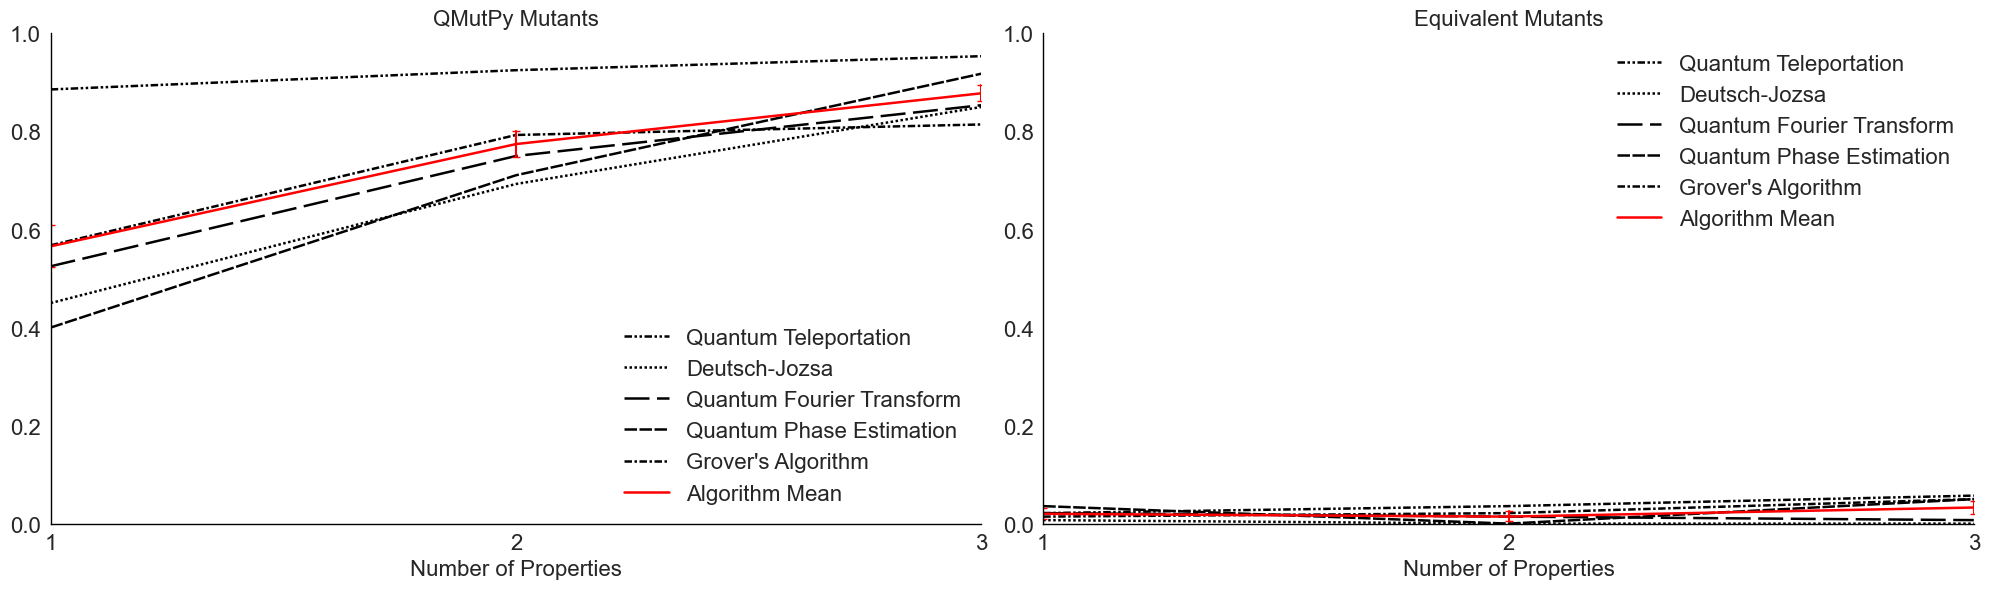

In [8]:
get_stats(all_df_c, group_by="Number of Properties", filter_by_feature=['Number of Measurements'], filter_by_values=[[1600, 3200]])
plot_linegraph(dfs, dfs_names, "Number of Properties", log_scale=False, cleaned_data=all_df_c, filter_by_feature=['Number of Measurements'], filter_by_values=[[1600, 3200]])

# RQ1.2: Effect of Number of Inputs per Property

Not Equivalent
STD NE
Number of Inputs
1     0.220512
2     0.209910
4     0.210483
8     0.205778
16    0.205267
32    0.188058
64    0.199146
Name: Result, dtype: float64
Median NE
Number of Inputs
1     0.70
2     0.75
4     0.75
8     0.80
16    0.80
32    0.85
64    0.85
Name: Result, dtype: float64
Mean NE
Number of Inputs
1     0.642963
2     0.685556
4     0.717407
8     0.733704
16    0.741852
32    0.760000
64    0.764444
Name: Result, dtype: float64
Pearson Correlation Coefficient NE
SignificanceResult(statistic=0.18967268510610133, pvalue=4.192719510798296e-09)
Equivalent
STD E
Number of Inputs
1     0.118550
2     0.139203
4     0.168225
8     0.190507
16    0.235965
32    0.255677
64    0.284330
Name: Result, dtype: float64
Median E
Number of Inputs
1     0.0
2     0.0
4     0.0
8     0.0
16    0.0
32    0.0
64    0.0
Name: Result, dtype: float64
Mean E
Number of Inputs
1     0.034074
2     0.047407
4     0.063704
8     0.085926
16    0.111852
32    0.138519
64    0.16814

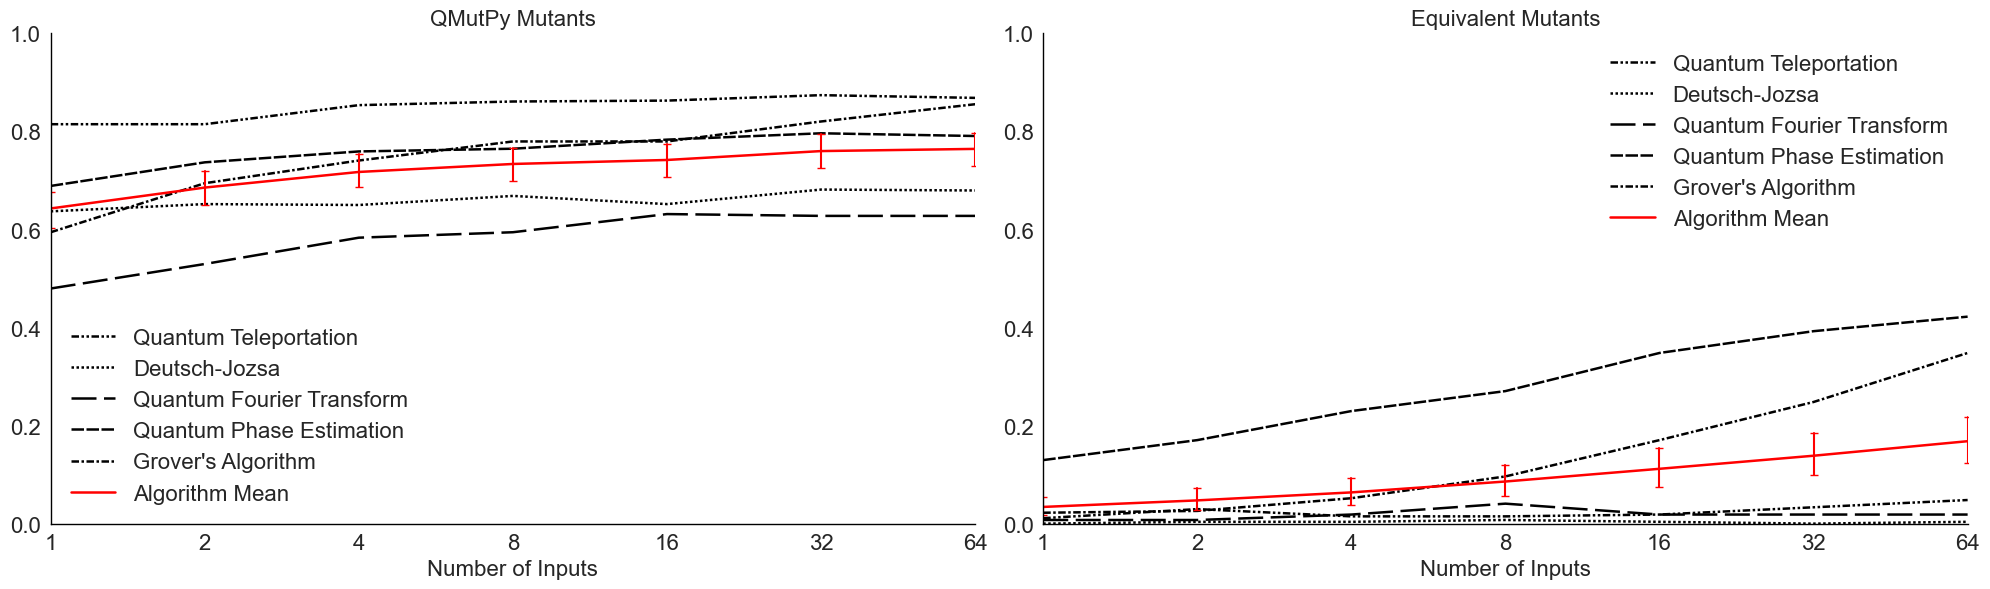

In [9]:
get_stats(all_df_c, group_by="Number of Inputs")
plot_linegraph(dfs, dfs_names, "Number of Inputs", log_scale=True, cleaned_data=all_df_c)

# Changing Number of Inputs, (1600, 3200) measurements and 3 properties

Not Equivalent
STD NE
Number of Inputs
1     0.088976
2     0.068516
4     0.058926
8     0.057975
16    0.068516
32    0.049721
64    0.055025
Name: Result, dtype: float64
Median NE
Number of Inputs
1     0.850
2     0.850
4     0.850
8     0.850
16    0.900
32    0.875
64    0.900
Name: Result, dtype: float64
Mean NE
Number of Inputs
1     0.825
2     0.855
4     0.875
8     0.885
16    0.905
32    0.895
64    0.905
Name: Result, dtype: float64
Pearson Correlation Coefficient NE
SignificanceResult(statistic=0.3373171251588662, pvalue=0.004295736678897279)
Equivalent
STD E
Number of Inputs
1     0.031623
2     0.042164
4     0.067495
8     0.051640
16    0.070711
32    0.048305
64    0.070711
Name: Result, dtype: float64
Median E
Number of Inputs
1     0.0
2     0.0
4     0.0
8     0.0
16    0.0
32    0.0
64    0.0
Name: Result, dtype: float64
Mean E
Number of Inputs
1     0.01
2     0.02
4     0.03
8     0.04
16    0.05
32    0.03
64    0.05
Name: Result, dtype: float64
Pearson Corre

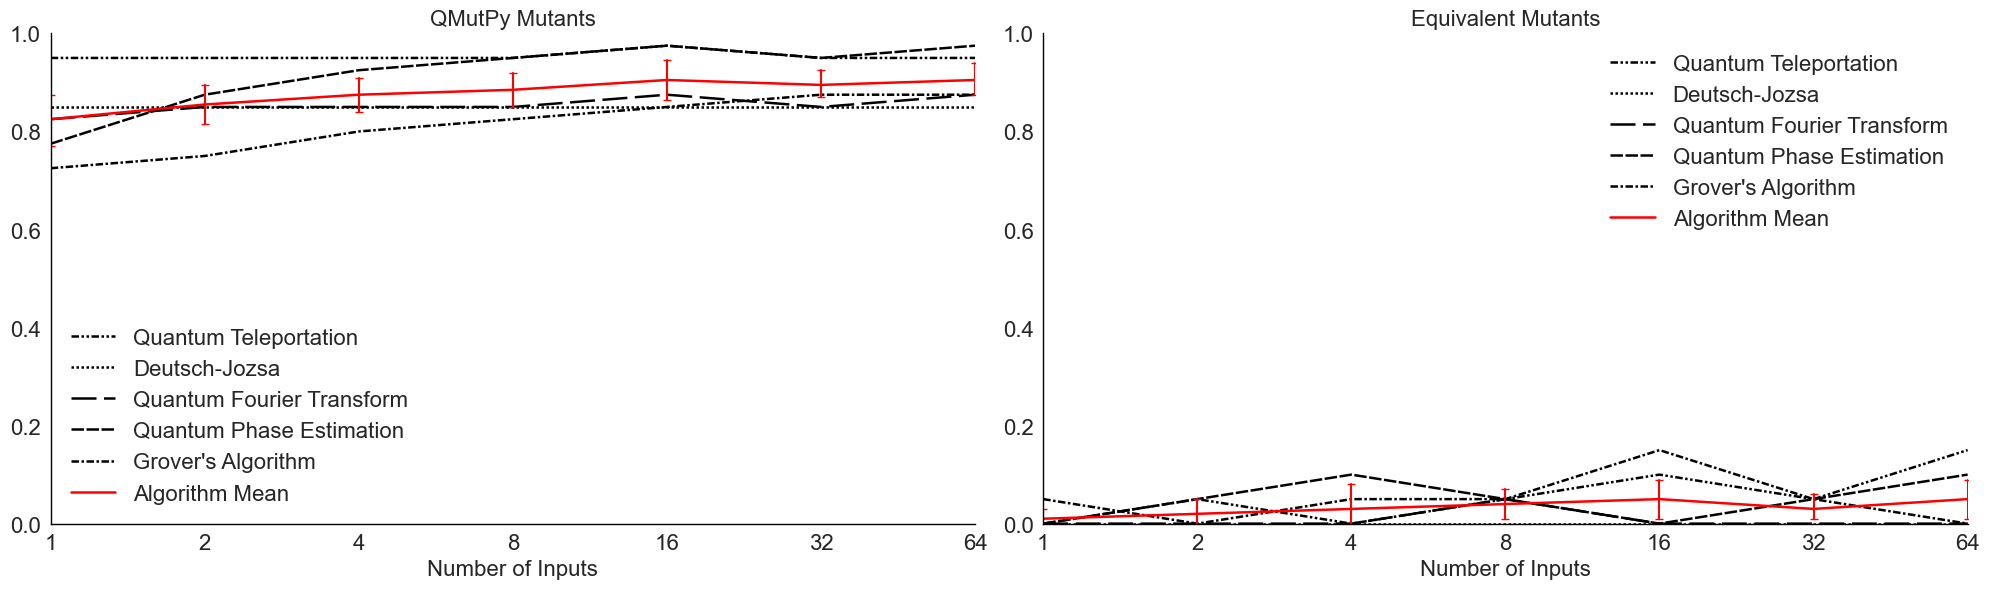

In [10]:
get_stats(all_df_c, group_by="Number of Inputs", filter_by_feature=['Number of Properties', 'Number of Measurements'], filter_by_values=[[3], [3200,1600]])
plot_linegraph(dfs, dfs_names, "Number of Inputs", log_scale=True, cleaned_data=all_df_c, filter_by_feature=['Number of Properties', 'Number of Measurements'], filter_by_values=[[3], [3200,1600]])


# RQ1.3: Effect of Measurement Shots

Not Equivalent
STD NE
Number of Measurements
12      0.263426
25      0.214192
50      0.205750
100     0.203666
200     0.194074
400     0.187612
800     0.187568
1600    0.191441
3200    0.184014
Name: Result, dtype: float64
Median NE
Number of Measurements
12      0.60
25      0.75
50      0.80
100     0.80
200     0.80
400     0.80
800     0.80
1600    0.80
3200    0.80
Name: Result, dtype: float64
Mean NE
Number of Measurements
12      0.597619
25      0.696667
50      0.745238
100     0.742381
200     0.742857
400     0.741905
800     0.742381
1600    0.734286
3200    0.744286
Name: Result, dtype: float64
Pearson Correlation Coefficient NE
SignificanceResult(statistic=0.11152084456259183, pvalue=0.0005938086929285911)
Equivalent
STD E
Number of Measurements
12      0.339435
25      0.316691
50      0.248095
100     0.205434
200     0.151095
400     0.095934
800     0.060492
1600    0.050997
3200    0.047425
Name: Result, dtype: float64
Median E
Number of Measurements
12      0.0


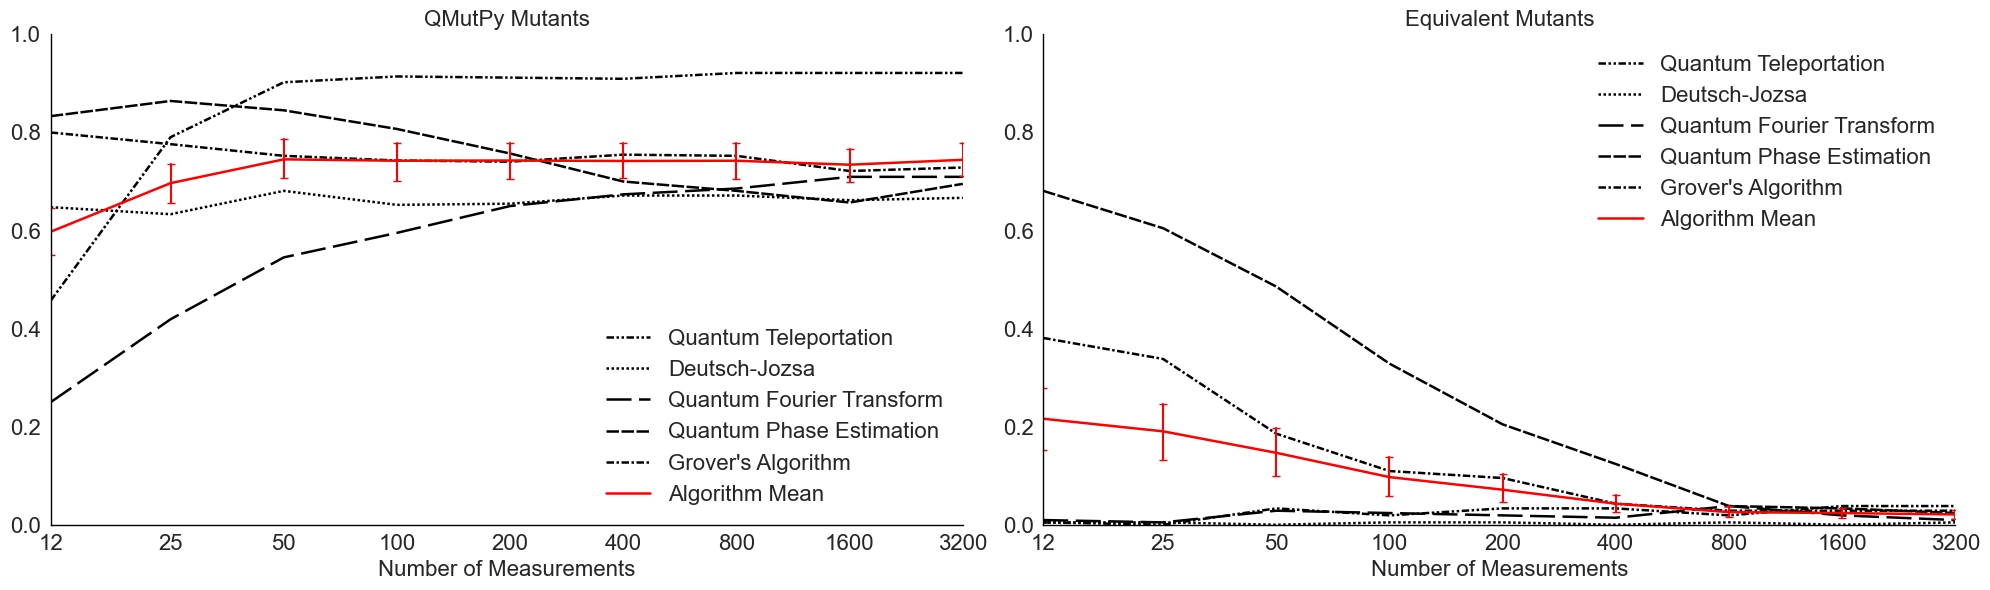

In [11]:
get_stats(all_df_c, group_by="Number of Measurements")
plot_linegraph(dfs, dfs_names, "Number of Measurements", log_scale=True, cleaned_data=all_df_c)

# RQ2: property-based testing effectiveness

In [12]:
def include_exp2(df):
    df = df[df["Number of Properties"].isin([3])]
    return df[df["Number of Measurements"].isin([4200, 2500])]

def clean_for_unit(dfs_list):
    for df in dfs_list:
        df["Equivalent"] = df['Mutant Name'].str.contains('_em')
        df["Algorithm"] = df["Mutant Name"].apply(lambda s: s.rsplit("_", 1)[0])
        df = df.groupby(["Number of Measurements", "Equivalent", "Algorithm"])['Result'].apply(lambda x: (x == 'Fail').sum() / (10.0 if x.name[1] else 20.0)).reset_index(name='Result')
        return df

all_df = []
all_df_c = []

qt_df = read_merged_data_to_dataframe("quantum_teleportation")
rd_qt_df = include_exp2(qt_df)
dj_df = read_merged_data_to_dataframe("deutsch_jozsa")
rd_dj_df = include_exp2(dj_df)
qft_df = read_merged_data_to_dataframe("quantum_fourier_transform")
rd_qft_df = include_exp2(qft_df)
qpe_df = read_merged_data_to_dataframe("quantum_phase_estimation")
rd_qpe_df = include_exp2(qpe_df)
grover_df = read_merged_data_to_dataframe("grovers_algorithm")
rd_grover_df = include_exp2(grover_df)

all_df = [rd_qt_df, rd_dj_df, rd_qft_df, rd_qpe_df, rd_grover_df]
all_df = pd.concat(all_df)

qt_df_c = clean([qt_df])
dj_df_c = clean([dj_df])
qft_df_c = clean([qft_df])
qpe_df_c = clean([qpe_df])
grover_df_c = clean([grover_df])
all_df_c = clean([all_df])

def read_merged_data_to_dataframe_single(algorithm_name, csv_filename):
    # Define the directory where the CSV files are stored
    filename = f"mutation_test_results/{algorithm_name}/{csv_filename}.csv"
    return pd.read_csv(filename)

def read_unit_test_data(algorithm_name):
    # Define the directory where the CSV files are stored
    filename = f"mutation_test_results/{algorithm_name}/{algorithm_name}_unit_tests.csv"
    return pd.read_csv(filename)

unit_qt_df = read_unit_test_data("quantum_teleportation")
unit_qt_df['Number of Measurements'].replace(100, 7500, inplace=True)
unit_dj_df = read_unit_test_data("deutsch_jozsa")
unit_qft_df = read_unit_test_data("quantum_fourier_transform")
# unit_qpe_df = read_unit_test_data("quantum_phase_estimation")
unit_grover_df = read_unit_test_data("grovers_algorithm")
unit_all_df = [unit_qt_df, unit_dj_df, unit_qft_df, unit_grover_df]
unit_all_df = pd.concat(unit_all_df)

unit_qt_df_c = clean_for_unit([unit_qt_df])
unit_dj_df_c = clean_for_unit([unit_dj_df])
unit_qft_df_c = clean_for_unit([unit_qft_df])
unit_grover_df_c = clean_for_unit([unit_grover_df])

unit_all_df_c = clean_for_unit([unit_all_df])

# print(all_df_c)
print(unit_all_df_c)

qs_qt_df = read_merged_data_to_dataframe_single("quantum_teleportation", "QTQS_in_out")
qs_sd_df = read_merged_data_to_dataframe_single("superdense_coding", "SDQS_correct_bits")

   Number of Measurements  Equivalent                  Algorithm  Result
0                    7500       False              deutsch_jozsa    0.85
1                    7500       False          grovers_algorithm    0.85
2                    7500       False  quantum_fourier_transform    0.75
3                    7500       False      quantum_teleportation    0.50
4                    7500        True              deutsch_jozsa    0.00
5                    7500        True          grovers_algorithm    0.00
6                    7500        True  quantum_fourier_transform    0.10
7                    7500        True      quantum_teleportation    0.00


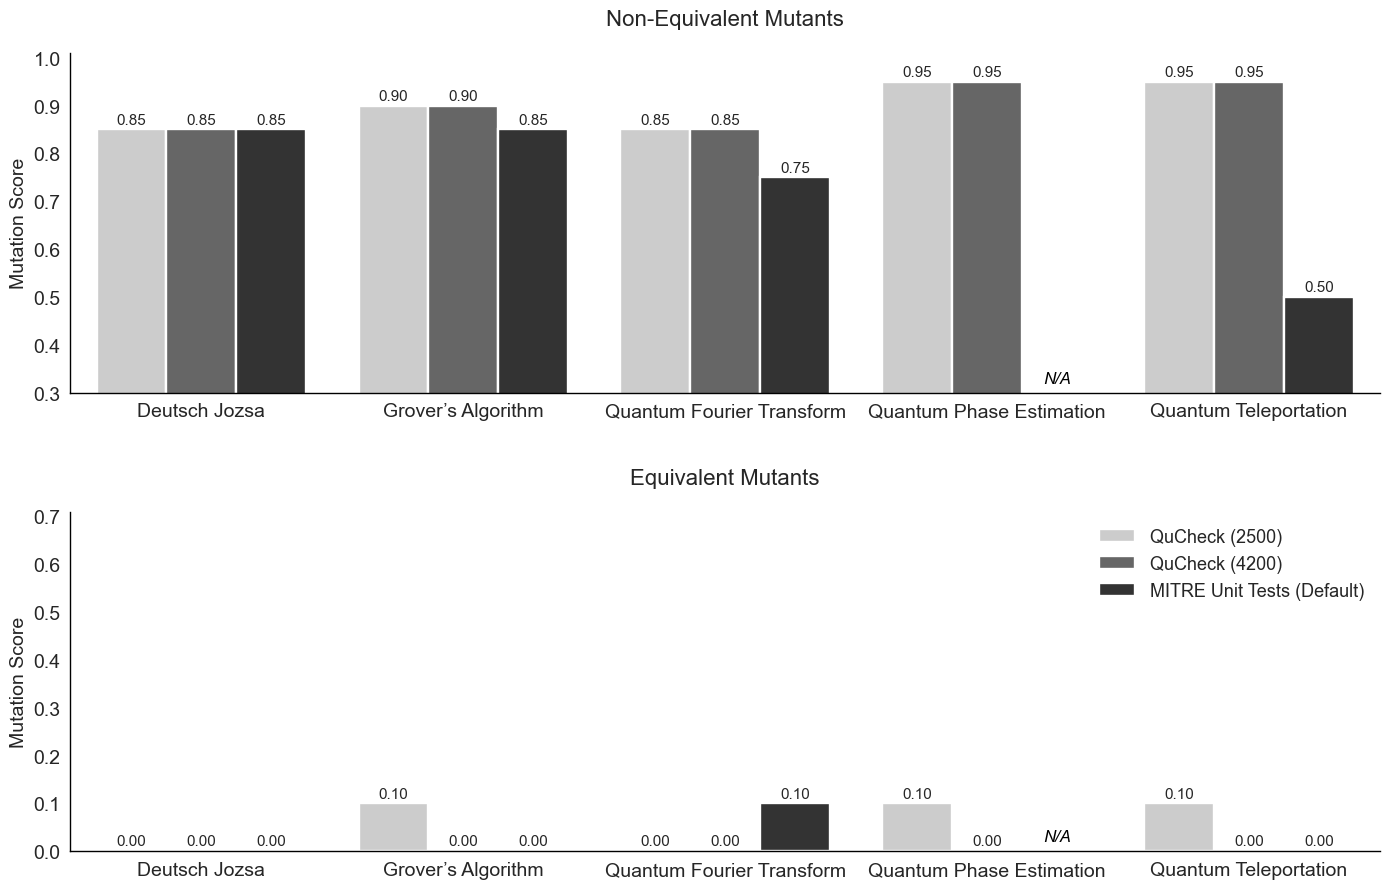

In [13]:
def plot_boxplot(all_df, unit_df):
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Label datasets
    all_df["Type"] = "Main"
    unit_df["Type"] = "Unit"

    # Ensure minimal required columns exist
    for col in ["Number of Inputs", "Number of Properties"]:
        if col not in all_df.columns:
            all_df[col] = 0
        if col not in unit_df.columns:
            unit_df[col] = 0

    unit_df = unit_df.dropna(subset=["Algorithm", "Result"])

    # Combine safely
    df = pd.concat([all_df, unit_df], ignore_index=True)

    # Filter measurements
    df_filtered = df[df["Number of Measurements"].isin([2500, 4200, 7500])].copy()

    # Beautify algorithm names
    name_map = {
        "deutsch_jozsa": "Deutsch Jozsa",
        "grovers_algorithm": "Grover’s Algorithm",
        "quantum_fourier_transform": "Quantum Fourier Transform",
        "quantum_phase_estimation": "Quantum Phase Estimation",
        "quantum_teleportation": "Quantum Teleportation",
    }
    df_filtered["Algorithm"] = df_filtered["Algorithm"].replace(name_map)

    # Split equivalent vs non-equivalent
    df_non_eq = df_filtered[df_filtered["Equivalent"] == False].copy()
    df_eq = df_filtered[df_filtered["Equivalent"] == True].copy()

    # Create Group label
    df_non_eq["Group"] = (
        df_non_eq["Number of Measurements"].astype(str)
        + " (" + df_non_eq["Type"] + ")"
    )
    df_eq["Group"] = (
        df_eq["Number of Measurements"].astype(str)
        + " (" + df_eq["Type"] + ")"
    )

    # Rename the legend/group labels
    rename_map = {
        "2500 (Main)": "QuCheck (2500)",
        "4200 (Main)": "QuCheck (4200)",
        "7500 (Unit)": "MITRE Unit Tests (Default)",
    }
    df_non_eq["Group"] = df_non_eq["Group"].replace(rename_map)
    df_eq["Group"] = df_eq["Group"].replace(rename_map)

    # Choose colors dynamically
    unique_groups = df_filtered["Number of Measurements"].astype(str).nunique()
    grays = ["#CCCCCC", "#666666", "#333333"][:unique_groups]

    # --- PLOT ---
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 9))

    # Non-equivalent mutants
    sns.barplot(
        ax=ax1,
        x="Algorithm",
        y="Result",
        hue="Group",
        data=df_non_eq,
        linewidth=1.7,
        palette=grays,
        gap=0,
        errorbar=None,
    )

    # Equivalent mutants
    sns.barplot(
        ax=ax2,
        x="Algorithm",
        y="Result",
        hue="Group",
        data=df_eq,
        linewidth=1.7,
        palette=grays,
        gap=0,
        errorbar=None,
    )

    # Label algorithms that are missing entirely (e.g. QPE)
    # missing_algorithms = ["Quantum Phase Estimation"]

    # for ax in [ax1, ax2]:
    #     tick_labels = [lbl.get_text() for lbl in ax.get_xticklabels()]
    #     for alg in missing_algorithms:
    #        print(df_filtered[df_filtered["Algorithm"] == alg]["Result"])

    missing_algorithm = "Quantum Phase Estimation"
    missing_group = "MITRE Unit Tests (Default)"

    for ax, subset in zip([ax1, ax2], [df_non_eq, df_eq]):
        tick_labels = [lbl.get_text() for lbl in ax.get_xticklabels()]
        if missing_algorithm not in tick_labels:
            continue

        xpos = tick_labels.index(missing_algorithm)

        # If QPE has no MITRE bar, mark where that bar should be
        if not ((subset["Algorithm"] == missing_algorithm) & (subset["Group"] == missing_group)).any():
            # number of hue categories
            hue_labels = ["QuCheck (2500)", "QuCheck (4200)", "MITRE Unit Tests (Default)"]
            n_hues = len(hue_labels)
            width = 0.8 / n_hues  # seaborn default bar group width ≈ 0.8 total

            # find horizontal offset for MITRE bar (last in hue order)
            hue_idx = hue_labels.index(missing_group)
            x_offset = (hue_idx - (n_hues - 1) / 2) * width

            # Place text at right-side bar position
            ax.text(
                xpos + x_offset,
                0.02,
                "N/A",
                ha="center",
                va="bottom",
                fontsize=12,
                color="black",
                fontstyle="italic",
                transform=ax.get_xaxis_transform(),
                zorder=10,
            )

    # Style and labels
    for ax, title in zip(
        [ax1, ax2],
        ["Non-Equivalent Mutants", "Equivalent Mutants"],
    ):
        ax.set_ylim(0, 1.01)
        ax.set_title(title, fontsize=16, pad=20)
        ax.grid(False)
        sns.despine(ax=ax)
        ax.set_xlabel(None)
        ax.set_ylabel("Mutation Score", fontsize=14)
        for spine in ["left", "bottom"]:
            ax.spines[spine].set_linewidth(1)
            ax.spines[spine].set_color("k")
        for item in ax.get_xticklabels() + ax.get_yticklabels():
            item.set_fontsize(14)
        for container in ax.containers:
            ax.bar_label(container, fmt="%.2f", fontsize=11, padding=2)
        ax.legend(title=None, frameon=False, fontsize=13)

    ax1.legend_.remove()
    ax1.set_ylim(0.3,1.01)
    ax2.set_ylim(0, 0.71)
    plt.tight_layout()
    fig.subplots_adjust(hspace=0.35)
    plt.savefig("rq2_effectiveness.svg", dpi=300, bbox_inches="tight")
    plt.show()



plot_boxplot(all_df_c, unit_all_df_c)

# RQ2, Table 3

In [14]:
def clean_and_add_time(dfs_list):
    for df in dfs_list:
        df["Equivalent"] = df['Mutant Name'].str.contains('_em')
        # df["Algorithm"] = df.apply(lambda x: x['Mutant Name'][:-4] if x['Equivalent'] else x['Mutant Name'][:-3], axis=1)
        df["Algorithm"] = df["Mutant Name"].apply(lambda s: s.rsplit("_", 1)[0])
        df2 = df.groupby(["Number of Measurements", "Number of Inputs", "Number of Properties", "Equivalent", "Algorithm"])['Result'].apply(lambda x: (x == 'Fail').sum() / (10.0 if x.name[3] else 20.0)).reset_index()
        df3 = df.groupby(["Number of Measurements", "Number of Inputs", "Number of Properties", "Equivalent", "Algorithm"])['Time Taken'].apply(lambda x: x.sum() / (10.0 if x.name[3] else 20.0)).reset_index()

        df = pd.merge(df2, df3, on=["Number of Measurements", "Number of Inputs", "Number of Properties", "Equivalent", "Algorithm"])
        return df

def clean_and_add_time_equiv_agnostic(dfs_list):
    for df in dfs_list:
        df["Equivalent"] = df['Mutant Name'].str.contains('_em')
        # df["Algorithm"] = df.apply(lambda x: x['Mutant Name'][:-4] if x['Equivalent'] else x['Mutant Name'][:-3], axis=1)
        df["Algorithm"] = df["Mutant Name"].apply(lambda s: s.rsplit("_", 1)[0])
        df = df.groupby(["Number of Measurements", "Number of Inputs", "Number of Properties", "Algorithm"])['Time Taken'].apply(lambda x: x.sum() / 30.0).reset_index()
        return df

# get the standard deviation of data for all algorithms from 1-3 properties and 50-3200 measurements, and 1-64 inputs
def get_time_stats(df, filter_by_feature=None, filter_by_values=None):
    res_df = df

    if filter_by_feature is not None:
        for i in range(len(filter_by_feature)):
            res_df = res_df[res_df[filter_by_feature[i]].isin(filter_by_values[i])]

    print(res_df[['Algorithm', 'Time Taken']])
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

# all_df
all_df_c = clean_and_add_time_equiv_agnostic([all_df])
get_time_stats(all_df_c, filter_by_feature=['Number of Properties', 'Number of Measurements', "Number of Inputs"], filter_by_values=[[3], [4200], [100]])
get_time_stats(all_df_c, filter_by_feature=['Number of Properties', 'Number of Measurements', "Number of Inputs"], filter_by_values=[[3], [2500], [100]])

                   Algorithm  Time Taken
5              deutsch_jozsa   11.498000
6          grovers_algorithm  123.454333
7  quantum_fourier_transform  121.312633
8   quantum_phase_estimation  413.807833
9      quantum_teleportation   19.085433
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                   Algorithm  Time Taken
0              deutsch_jozsa    9.870100
1          grovers_algorithm  121.937733
2  quantum_fourier_transform  107.055400
3   quantum_phase_estimation  298.335167
4      quantum_teleportation   15.170033
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


# RQ3.2: Quantitative differences

In [60]:
# def clean_and_add_time(dfs_list):
#     for df in dfs_list:
#         df["Equivalent"] = df['Mutant Name'].str.contains('_em')
#         df["Algorithm"] = df.apply(lambda x: x['Mutant Name'][:-4] if x['Equivalent'] else x['Mutant Name'][:-3], axis=1)
#         return df

def get_stats_(df, group_by="Number of Properties", filter_by_feature=None, filter_by_values=None):
    failure_rate = df[df['Equivalent'] == False]
    pass_rate = df[df['Equivalent'] == True]

    if filter_by_feature is not None:
        for i in range(len(filter_by_feature)):
            failure_rate = failure_rate[failure_rate[filter_by_feature[i]].isin(filter_by_values[i])]
            pass_rate = pass_rate[pass_rate[filter_by_feature[i]].isin(filter_by_values[i])]

    print("Not Equivalent")

    if group_by is not None:
        print("STD NE")
        print(failure_rate.groupby(group_by)['Result'].std())
        print("Median NE")
        print(failure_rate.groupby(group_by)['Result'].median())
        print("Mean NE")
        print(failure_rate.groupby(group_by)['Result'].mean())
        print("Pearson Correlation Coefficient NE")
        print(scipy.stats.spearmanr(failure_rate[group_by], failure_rate["Result"], alternative='two-sided'))
    else:
        print("STD NE")
        print(failure_rate['Result'].std())
        print("Median NE")
        print(failure_rate['Result'].median())
        print("Mean NE")
        print(failure_rate['Result'].mean())

    print("Equivalent")

    if group_by is not None:
        print("STD E")
        print(pass_rate.groupby(group_by)['Result'].std())
        print("Median E")
        print(pass_rate.groupby(group_by)['Result'].median())
        print("Mean E")
        print(pass_rate.groupby(group_by)['Result'].mean())
        print("Pearson Correlation Coefficient E")
        print(scipy.stats.spearmanr(pass_rate[group_by], pass_rate["Result"], alternative='two-sided'))
    else:
        print("STD E")
        print(pass_rate['Result'].std())
        print("Median E")
        print(pass_rate['Result'].median())
        print("Mean E")
        print(pass_rate['Result'].mean())

def clean_and_add_time(dfs_list):
    for df in dfs_list:
        df["Equivalent"] = df['Mutant Name'].str.contains('_em')
        # df["Algorithm"] = df.apply(lambda x: x['Mutant Name'][:-4] if x['Equivalent'] else x['Mutant Name'][:-3], axis=1)
        df["Algorithm"] = df["Mutant Name"].apply(lambda s: s.rsplit("_", 1)[0])
        # df2 = df.groupby(["Number of Measurements", "Number of Inputs", "Equivalent", "Algorithm"])['Result'].apply(lambda x: (x == 'Fail').sum() / (10.0 if x.name[3] else 20.0)).reset_index()
        # df3 = df.groupby(["Number of Measurements", "Number of Inputs", "Equivalent", "Algorithm"])['Time Taken'].apply(lambda x: x.sum() / (10.0 if x.name[3] else 20.0)).reset_index()

        # df = pd.merge(df2, df3, on=["Number of Measurements", "Number of Inputs", "Equivalent", "Algorithm"])
        return df

df1 = pd.read_csv(f"mutation_test_results/quantum_teleportation/QTQS_in_out.csv")
df2 = pd.read_csv(f"mutation_test_results/superdense_coding/SDQS_correct_bits.csv")
qsharp = pd.concat([df1, df2])
df1 = pd.read_csv(f"mutation_test_results/quantum_teleportation/quantum_teleportation_in_out_eq_merged_results.csv")
df2 = pd.read_csv(f"mutation_test_results/superdense_coding/superdense_coding_correct_bits_merged_results.csv")
qcheck = pd.concat([df1, df2])


In [61]:
qsharp = clean_and_add_time([qsharp])
qsharp

,Mutant Name,Result,Time Taken,Compile Time,Number of Measurements,config,Number of Inputs,Equivalent,Algorithm
0,quantum_teleportation_m0,Fail,0.715,4.97,12600,90x140,100,False,quantum_teleportation
1,quantum_teleportation_m1,Fail,0.645,5.00,12600,90x140,100,False,quantum_teleportation
2,quantum_teleportation_m2,Pass,55.923,5.05,12600,90x140,100,False,quantum_teleportation
3,quantum_teleportation_m3,Pass,57.336,5.05,12600,90x140,100,False,quantum_teleportation
4,quantum_teleportation_m4,Pass,57.403,5.01,12600,90x140,100,False,quantum_teleportation
...,...,...,...,...,...,...,...,...,...
55,superdense_coding_em5,Pass,26.870,5.08,7500,7500,100,True,superdense_coding
56,superdense_coding_em6,Pass,26.752,5.57,7500,7500,100,True,superdense_coding
57,superdense_coding_em7,Pass,25.206,4.85,7500,7500,100,True,superdense_coding
58,superdense_coding_em8,Pass,27.740,5.00,7500,7500,100,True,superdense_coding


In [62]:
qcheck = clean_and_add_time([qcheck])
qcheck

,Mutant Name,Number of Properties,Number of Inputs,Number of Measurements,Result,Number of Circuits Executed,Number of Unique Failed Properties,Number of Failed Properties,Unique Failed Properties,Time Taken,Equivalent,Algorithm
0,quantum_teleportation_em0,1,100,2500,Pass,600,0,0,NaN,4.107,True,quantum_teleportation
1,quantum_teleportation_em1,1,100,2500,Pass,600,0,0,NaN,4.043,True,quantum_teleportation
2,quantum_teleportation_em2,1,100,2500,Pass,600,0,0,NaN,4.123,True,quantum_teleportation
3,quantum_teleportation_em3,1,100,2500,Pass,600,0,0,NaN,4.067,True,quantum_teleportation
4,quantum_teleportation_em4,1,100,2500,Pass,600,0,0,NaN,4.154,True,quantum_teleportation
...,...,...,...,...,...,...,...,...,...,...,...,...
55,superdense_coding_m5,1,100,4200,Fail,24,1,54,CorrectBitsSent,5.171,False,superdense_coding
56,superdense_coding_m6,1,100,4200,Pass,24,0,0,NaN,5.065,False,superdense_coding
57,superdense_coding_m7,1,100,4200,Fail,24,1,100,CorrectBitsSent,5.109,False,superdense_coding
58,superdense_coding_m8,1,100,4200,Fail,24,1,44,CorrectBitsSent,5.102,False,superdense_coding


In [63]:
# get_stats_(qsharp, group_by='Number of Measurements', filter_by_feature=['Number of Measurements', 'Number of Inputs'], filter_by_values=[[9600, 4800], [64, 32]], feature_str="Time Taken")
get_stats(qsharp, group_by='Number of Measurements', filter_by_feature=['Number of Measurements', 'Number of Inputs'], filter_by_values=[[12600, 7500], [100]], feature_str="Time Taken")

Not Equivalent
STD NE
Number of Measurements
7500     15.637334
12600    25.480407
Name: Time Taken, dtype: float64
Median NE
Number of Measurements
7500     0.953
12600    0.744
Name: Time Taken, dtype: float64
Mean NE
Number of Measurements
7500     14.081450
12600    20.678325
Name: Time Taken, dtype: float64
Pearson Correlation Coefficient NE
SignificanceResult(statistic=0.14731958926138727, pvalue=0.19221432643683065)
Equivalent
STD E
Number of Measurements
7500      7.035123
12600    10.098782
Name: Time Taken, dtype: float64
Median E
Number of Measurements
7500     32.4800
12600    55.8415
Name: Time Taken, dtype: float64
Mean E
Number of Measurements
7500     31.63115
12600    54.18430
Name: Time Taken, dtype: float64
Pearson Correlation Coefficient E
SignificanceResult(statistic=0.8489702403754517, pvalue=4.467258222809812e-12)


In [45]:
qcheck = clean_and_add_time([qcheck])
# qcheck
get_stats(qcheck, group_by='Number of Measurements', filter_by_feature=['Number of Measurements', 'Number of Inputs'], filter_by_values=[[4200, 2500], [100]], feature_str="Time Taken")

Not Equivalent
STD NE
Number of Measurements
2500    1.298788
4200    1.875581
Name: Time Taken, dtype: float64
Median NE
Number of Measurements
2500    4.9100
4200    5.2775
Name: Time Taken, dtype: float64
Mean NE
Number of Measurements
2500    5.196225
4200    6.122075
Name: Time Taken, dtype: float64
Pearson Correlation Coefficient NE
SignificanceResult(statistic=0.33128059925543174, pvalue=0.0026849480278558786)
Equivalent
STD E
Number of Measurements
2500    0.715069
4200    1.258674
Name: Time Taken, dtype: float64
Median E
Number of Measurements
2500    3.2585
4200    4.0100
Name: Time Taken, dtype: float64
Mean E
Number of Measurements
2500    3.32445
4200    4.12560
Name: Time Taken, dtype: float64
Pearson Correlation Coefficient E
SignificanceResult(statistic=0.39853362292533, pvalue=0.01086151440005562)


In [64]:
# calculate mean execution time when measurements are 4800 and 9600, and inputs are 32 and 64 and equivalent mutants are included

Mean_NE_QS = (14.081450 + 20.678325)/2
print(Mean_NE_QS)
Mean_E_QS = (31.63115 + 54.18430)/2
print(Mean_E_QS)
Mean_NE_Qu = (5.196225 + 6.122075)/2
print(Mean_NE_Qu)
Mean_E_Qu = (3.32445 + 4.12560)/2
print(Mean_E_Qu)

NE_percent_decrease = ((Mean_NE_QS - Mean_NE_Qu) / Mean_NE_QS) * 100
print(NE_percent_decrease)
E_percent_decrease = ((Mean_E_QS - Mean_E_Qu) / Mean_E_QS) * 100
print(E_percent_decrease)

QS_mean = (Mean_NE_QS + Mean_E_QS) / 2
Qu_mean = (Mean_NE_Qu + Mean_E_Qu) / 2
Qu_QS_percent_decrease = ((QS_mean - Qu_mean) / QS_mean) * 100
print(Qu_QS_percent_decrease)

17.379887500000002
42.907725
5.65915
3.7250250000000005
67.43851190060926
91.31852131521771
84.43432305434222


0
Axes(0.125,0.53;0.352273x0.35)
1
Axes(0.547727,0.53;0.352273x0.35)
2
Axes(0.125,0.11;0.352273x0.35)
3
Axes(0.547727,0.11;0.352273x0.35)


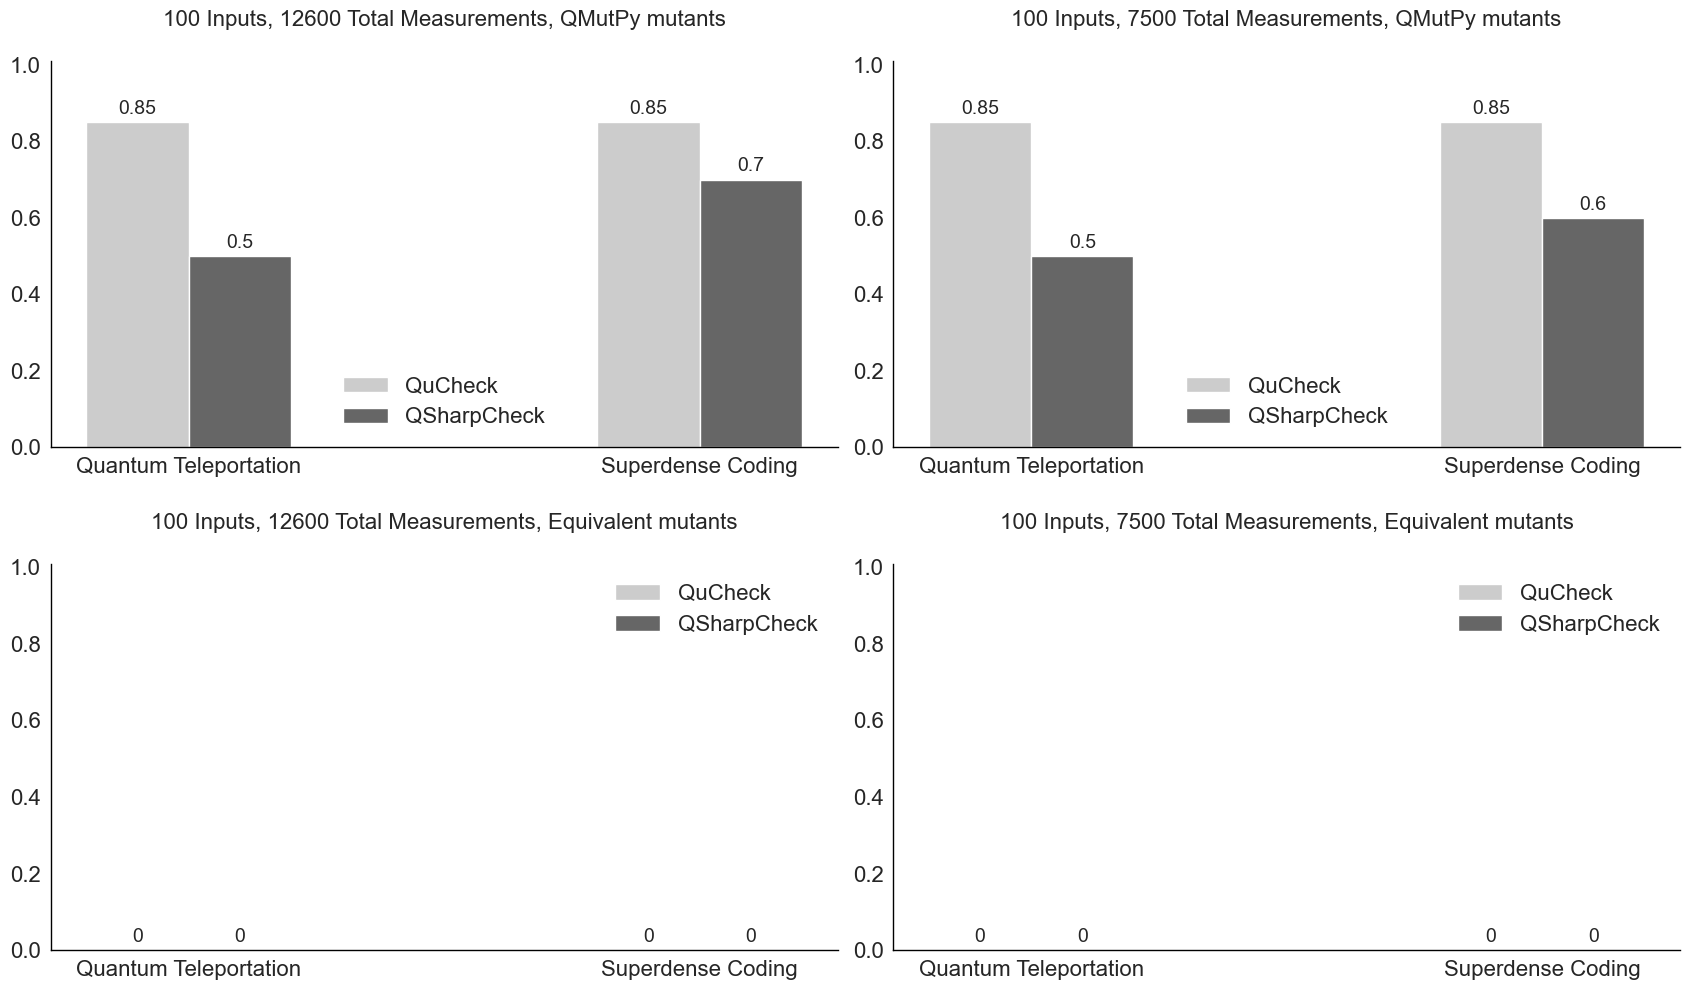

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_quantitative_analysis_comparison(qs_qt_df, qt_df, qs_sd_df, sd_df, feature_str):
    # Define configurations
    configs = [
        {'measurements': 4200, 'inputs': 100},
        {'measurements': 2500, 'inputs': 100},
        # {'measurements': 3200, 'inputs': 32},
        # {'measurements': 1600, 'inputs': 32}
    ]

    # fig, axes = plt.subplots(2, 2, figsize=(17, 10))
    fig, axes = plt.subplots(2, 2, figsize=(17, 10))
    # fig.suptitle('Comparison of Q# and Qiskit mutation testing of quantum teleportation', fontsize=16)

    for idx in range(4):
        print(idx)
        ax = axes[idx // 2, idx % 2]
        print(ax)
        measurements_qc = configs[idx%2]['measurements']

        # Filter data for the current configuration
        qs_qt_df_filtered = qs_qt_df[
            (qs_qt_df['Number of Measurements'] == measurements_qc*3) &
            (qs_qt_df['Number of Inputs'] == 100)
        ]

        # Filter data for the current configuration
        qt_df_filtered = qt_df[
            (qt_df['Number of Measurements'] == measurements_qc) &
            (qt_df['Number of Inputs'] == 100)
        ]
    #
        qs_sd_df_filtered = qs_sd_df[
            (qs_sd_df['Number of Measurements'] == measurements_qc*3) &
            (qs_sd_df['Number of Inputs'] == 100)
        ]

        sd_df_filtered = sd_df[
            (sd_df['Number of Measurements'] == measurements_qc) &
            (sd_df['Number of Inputs'] == 100)
        ]

        # Q# results (assumed to be the same for all configurations)
        qs_qt_df_non_equivalent = qs_qt_df_filtered[qs_qt_df_filtered['Mutant Name'].str.contains('_m')]
        qs_non_equiv_failures = (qs_qt_df_non_equivalent["Result"] == 'Fail').mean()

        qs_sd_df_non_equivalent = qs_sd_df_filtered[qs_sd_df_filtered['Mutant Name'].str.contains('_m')]
        qs_sd_non_equiv_failures = (qs_sd_df_non_equivalent["Result"] == 'Fail').mean()

        qs_qt_df_equivalent = qs_qt_df_filtered[qs_qt_df_filtered['Mutant Name'].str.contains('_em')]
        qs_equiv_failures = (qs_qt_df_equivalent["Result"] == 'Fail').mean()

        qs_sd_df_equivalent = qs_sd_df_filtered[qs_sd_df_filtered['Mutant Name'].str.contains('_em')]
        qs_sd_equiv_failures = (qs_sd_df_equivalent["Result"] == 'Fail').mean()

        # Qiskit results
        qt_df_non_equivalent = qt_df_filtered[qt_df_filtered['Mutant Name'].str.contains('_m')]
        qt_non_equiv_failures = (qt_df_non_equivalent[feature_str] == 'Fail').mean()

        sd_df_non_equivalent = sd_df_filtered[sd_df_filtered['Mutant Name'].str.contains('_m')]
        sd_non_equiv_failures = (sd_df_non_equivalent[feature_str] == 'Fail').mean()

        qt_df_equivalent = qt_df_filtered[qt_df_filtered['Mutant Name'].str.contains('_em')]
        qt_equiv_failures = (qt_df_equivalent[feature_str] == 'Fail').mean()

        sd_df_equivalent = sd_df_filtered[sd_df_filtered['Mutant Name'].str.contains('_em')]
        sd_equiv_failures = (sd_df_equivalent[feature_str] == 'Fail').mean()
    #
        # Prepare data for plotting
        algorithms = [
        "Quantum Teleportation",
        "Superdense Coding",
        ]

        qiskit_results = []
        if idx // 2 == 0:
            qiskit_results = np.array([
                qt_non_equiv_failures,
                sd_non_equiv_failures
            ])
        else:
            qiskit_results = np.array([
                qt_equiv_failures,
                sd_equiv_failures
            ])

        qs_results = []
        if idx // 2 == 0:
            qs_results = np.array([
                qs_non_equiv_failures,
                qs_sd_non_equiv_failures
            ])
        else:
            qs_results = np.array([
                qs_equiv_failures,
                qs_sd_equiv_failures
            ])


        # Create the plot
        x = np.arange(len(algorithms))
        width = 0.2

        grays = ["#CCCCCC", "#666666"]

        rects1 = ax.bar(x - width/2, qiskit_results, width, color=grays[0], label='QuCheck', alpha=1)
        rects2 = ax.bar(x + width/2, qs_results, width, color=grays[1], label='QSharpCheck', alpha=1)
    #
        if idx//2 == 0:
            ax.set_title(f'100 Inputs, {measurements_qc*3} Total Measurements, QMutPy mutants', fontsize=16, pad=25)
        else:
            ax.set_title(f'100 Inputs, {measurements_qc*3} Total Measurements, Equivalent mutants', fontsize=16, pad=25)
        ax.set_xticks(x)
        ax.set_xticklabels(algorithms)
        ax.legend()
    #
        ax.bar_label(rects1, padding=3, fontsize=14)
        ax.bar_label(rects2, padding=3, fontsize=14)
    #
        for item in ax.get_xticklabels() + ax.get_xticklabels() + ax.get_yticklabels() + ax.get_yticklabels():
            item.set_fontsize(16)

        ax.set(ylabel=None)
        ax.spines['left'].set_linewidth(1)
        ax.spines['left'].set_color('k')
        ax.spines['bottom'].set_linewidth(1)
        ax.spines['bottom'].set_color('k')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.legend(frameon=False, fontsize=16)
    #
    #
        ax.set_ylim(0, 1.01)
        ax.grid(False)
    #
    plt.tight_layout()
    fig.subplots_adjust(hspace=0.3)
    # # plt.savefig(f"quantitative_comparison_configs.svg", dpi=100, bbox_inches='tight')
    plt.savefig(f"quantitative_comparison_configs.svg", dpi=300, bbox_inches='tight')
    plt.show()

# To use this function, uncomment the following lines and run the script:
df1 = pd.read_csv(f"mutation_test_results/quantum_teleportation/QTQS_in_out.csv")
df2 = pd.read_csv(f"mutation_test_results/quantum_teleportation/quantum_teleportation_in_out_eq_merged_results.csv")
df3 = pd.read_csv(f"mutation_test_results/superdense_coding/SDQS_correct_bits.csv")
df4 = pd.read_csv(f"mutation_test_results/superdense_coding/superdense_coding_correct_bits_merged_results.csv")
plot_quantitative_analysis_comparison(df1, df2, df3, df4, "Result")

0
Axes(0.125,0.53;0.352273x0.35)
1
Axes(0.547727,0.53;0.352273x0.35)
2
Axes(0.125,0.11;0.352273x0.35)
3
Axes(0.547727,0.11;0.352273x0.35)


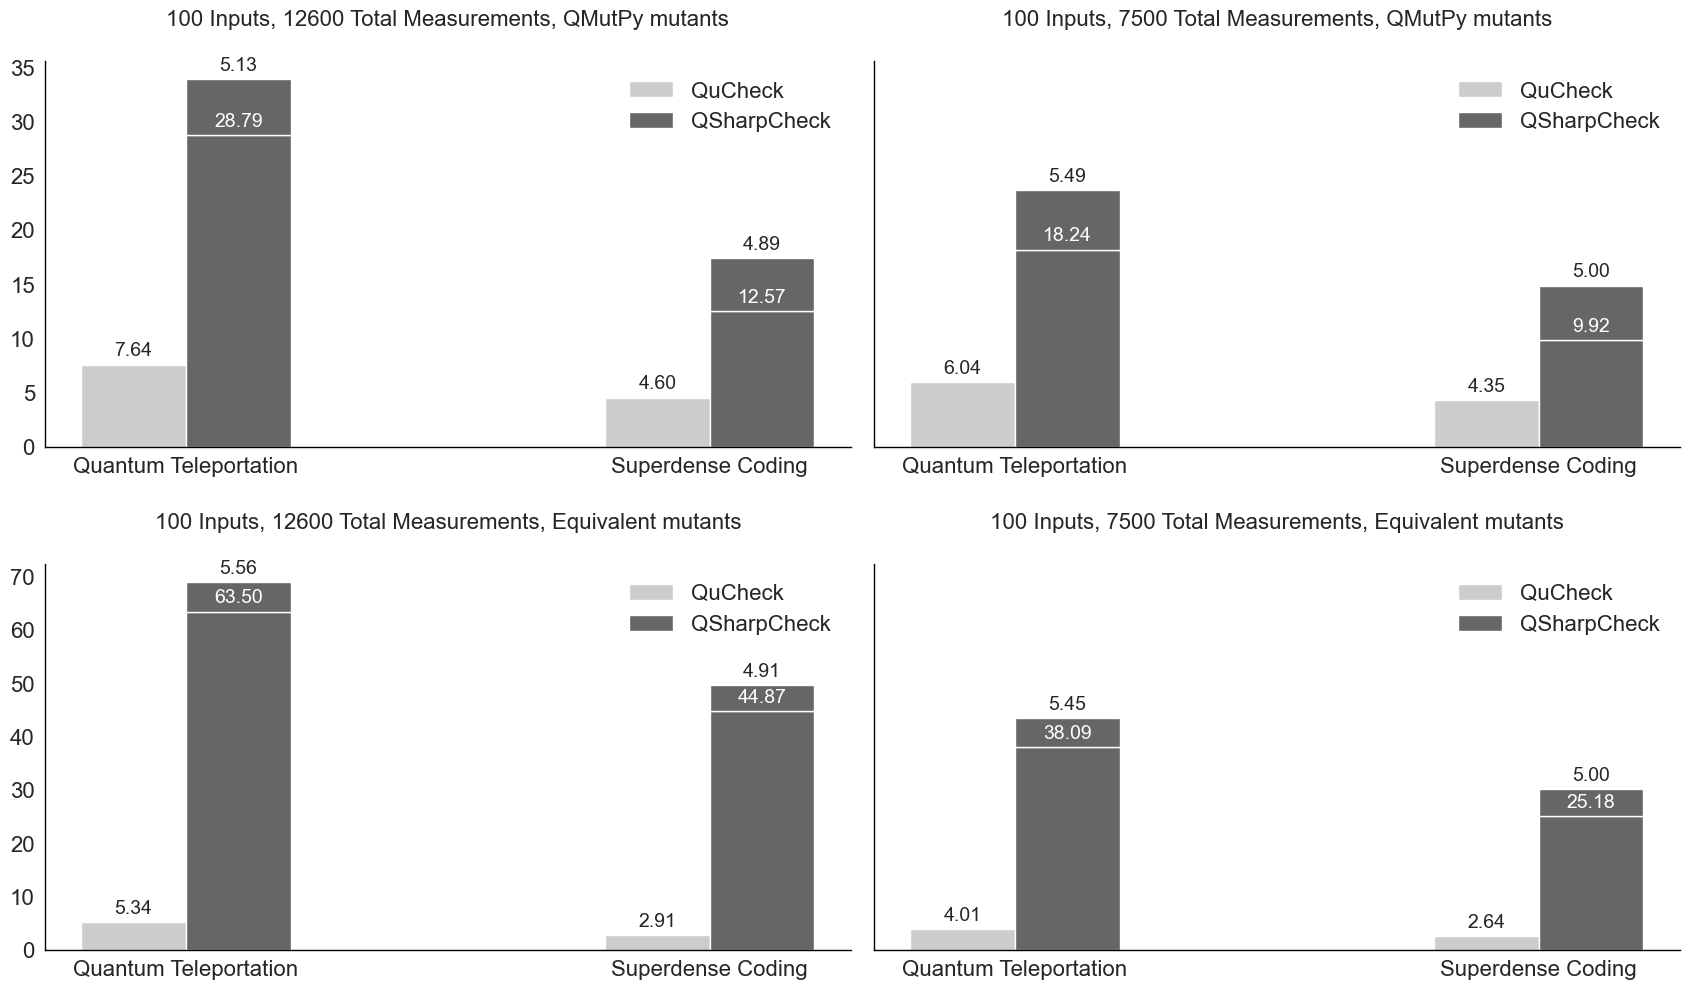

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_quantitative_analysis_comparison(qs_qt_df, qt_df, qs_sd_df, sd_df, feature_str):
    # Define configurations
    configs = [
        {'measurements': 4200, 'inputs': 100},
        {'measurements': 2500, 'inputs': 100},
        # {'measurements': 3200, 'inputs': 32},
        # {'measurements': 1600, 'inputs': 32}
    ]

    # fig, axes = plt.subplots(2, 2, figsize=(17, 10))
    fig, axes = plt.subplots(2, 2, figsize=(17, 10), sharey="row")
    # fig.suptitle('Comparison of Q# and Qiskit mutation testing of quantum teleportation', fontsize=16)

    for idx in range(4):
        print(idx)
        ax = axes[idx // 2, idx % 2]
        print(ax)
        measurements_qc = configs[idx%2]['measurements']

        # Filter data for the current configuration
        qs_qt_df_filtered = qs_qt_df[
            (qs_qt_df['Number of Measurements'] == measurements_qc*3) &
            (qs_qt_df['Number of Inputs'] == 100)
        ]

        # Filter data for the current configuration
        qt_df_filtered = qt_df[
            (qt_df['Number of Measurements'] == measurements_qc) &
            (qt_df['Number of Inputs'] == 100)
        ]
    #
        qs_sd_df_filtered = qs_sd_df[
            (qs_sd_df['Number of Measurements'] == measurements_qc*3) &
            (qs_sd_df['Number of Inputs'] == 100)
        ]

        sd_df_filtered = sd_df[
            (sd_df['Number of Measurements'] == measurements_qc) &
            (sd_df['Number of Inputs'] == 100)
        ]

        # Q# results (assumed to be the same for all configurations)
        qs_qt_df_non_equivalent = qs_qt_df_filtered[qs_qt_df_filtered['Mutant Name'].str.contains('_m')]
        qs_non_equiv_failures = qs_qt_df_non_equivalent["Time Taken"].mean()
        qs_non_equiv_failures_compile = qs_qt_df_non_equivalent["Compile Time"].mean()

        qs_sd_df_non_equivalent = qs_sd_df_filtered[qs_sd_df_filtered['Mutant Name'].str.contains('_m')]
        qs_sd_non_equiv_failures = qs_sd_df_non_equivalent["Time Taken"].mean()
        qs_sd_non_equiv_failures_compile = qs_sd_df_non_equivalent["Compile Time"].mean()

        qs_qt_df_equivalent = qs_qt_df_filtered[qs_qt_df_filtered['Mutant Name'].str.contains('_em')]
        qs_equiv_failures = qs_qt_df_equivalent["Time Taken"].mean()
        qs_equiv_failures_compile = qs_qt_df_equivalent["Compile Time"].mean()

        qs_sd_df_equivalent = qs_sd_df_filtered[qs_sd_df_filtered['Mutant Name'].str.contains('_em')]
        qs_sd_equiv_failures = qs_sd_df_equivalent["Time Taken"].mean()
        qs_sd_equiv_failures_compile = qs_sd_df_equivalent["Compile Time"].mean()

        # Qiskit results
        qt_df_non_equivalent = qt_df_filtered[qt_df_filtered['Mutant Name'].str.contains('_m')]
        qt_non_equiv_failures = qt_df_non_equivalent["Time Taken"].mean()

        sd_df_non_equivalent = sd_df_filtered[sd_df_filtered['Mutant Name'].str.contains('_m')]
        sd_non_equiv_failures = sd_df_non_equivalent["Time Taken"].mean()

        qt_df_equivalent = qt_df_filtered[qt_df_filtered['Mutant Name'].str.contains('_em')]
        qt_equiv_failures = qt_df_equivalent["Time Taken"].mean()

        sd_df_equivalent = sd_df_filtered[sd_df_filtered['Mutant Name'].str.contains('_em')]
        sd_equiv_failures = sd_df_equivalent["Time Taken"].mean()
    #
        # Prepare data for plotting
        algorithms = [
        "Quantum Teleportation",
        "Superdense Coding",
        ]

        qs_results_compile = np.array([qs_non_equiv_failures_compile, qs_sd_non_equiv_failures_compile, qs_equiv_failures_compile, qs_sd_equiv_failures_compile])

        qiskit_results = []
        if idx // 2 == 0:
            qiskit_results = np.array([
                qt_non_equiv_failures,
                sd_non_equiv_failures
            ])
        else:
            qiskit_results = np.array([
                qt_equiv_failures,
                sd_equiv_failures
            ])

        qs_results = []
        if idx // 2 == 0:
            qs_results = np.array([
                qs_non_equiv_failures,
                qs_sd_non_equiv_failures
            ])
        else:
            qs_results = np.array([
                qs_equiv_failures,
                qs_sd_equiv_failures
            ])

        qs_results_compile = []
        if idx // 2 == 0:
            qs_results_compile = np.array([
                qs_non_equiv_failures_compile,
                qs_sd_non_equiv_failures_compile,
            ])
        else:
            qs_results_compile = np.array([
                qs_equiv_failures_compile,
                qs_sd_equiv_failures_compile
            ])


        # Create the plot
        x = np.arange(len(algorithms))
        width = 0.2

        grays = ["#CCCCCC", "#666666"]

        rects1 = ax.bar(x - width/2, qiskit_results, width, color=grays[0], label='QuCheck', alpha=1)
        rects2 = ax.bar(x + width/2, qs_results, width, color=grays[1], label='QSharpCheck', alpha=1)
        rects4 = ax.bar(x + width/2, qs_results_compile, width, color=grays[1], alpha=1, bottom=qs_results)


    #
        if idx//2 == 0:
            ax.set_title(f'100 Inputs, {measurements_qc*3} Total Measurements, QMutPy mutants', fontsize=16, pad=25)
        else:
            ax.set_title(f'100 Inputs, {measurements_qc*3} Total Measurements, Equivalent mutants', fontsize=16, pad=25)
        ax.set_xticks(x)
        ax.set_xticklabels(algorithms)
        ax.legend()
    #
        # ax.bar_label(rects1, padding=3, fontsize=14)
        # ax.bar_label(rects2, padding=3, fontsize=14)
        ax.bar_label(rects1, padding=3, fontsize=14, labels=[f"{x:.2f}" for x in qiskit_results])
        ax.bar_label(rects2, padding=3, fontsize=14, color='white', labels=[f"{x:.2f}" for x in qs_results])
        ax.bar_label(rects4, padding=3, fontsize=14, labels=[f"{x:.2f}" for x in qs_results_compile])

    #
        for item in ax.get_xticklabels() + ax.get_xticklabels() + ax.get_yticklabels() + ax.get_yticklabels():
            item.set_fontsize(16)

        ax.set(ylabel=None)
        ax.spines['left'].set_linewidth(1)
        ax.spines['left'].set_color('k')
        ax.spines['bottom'].set_linewidth(1)
        ax.spines['bottom'].set_color('k')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.legend(frameon=False, fontsize=16)
    #
    #
        # ax.set_ylim(0, 1.01)
        ax.grid(False)
    #
    plt.tight_layout()
    fig.subplots_adjust(hspace=0.3)
    # # plt.savefig(f"quantitative_comparison_configs.svg", dpi=100, bbox_inches='tight')
    plt.savefig(f"quantitative_comparison_time.svg", dpi=300, bbox_inches='tight')
    plt.show()

# To use this function, uncomment the following lines and run the script:
df1 = pd.read_csv(f"mutation_test_results/quantum_teleportation/QTQS_in_out.csv")
df2 = pd.read_csv(f"mutation_test_results/quantum_teleportation/quantum_teleportation_in_out_eq_merged_results.csv")
df3 = pd.read_csv(f"mutation_test_results/superdense_coding/SDQS_correct_bits.csv")
df4 = pd.read_csv(f"mutation_test_results/superdense_coding/superdense_coding_correct_bits_merged_results.csv")
plot_quantitative_analysis_comparison(df1, df2, df3, df4, "Result")

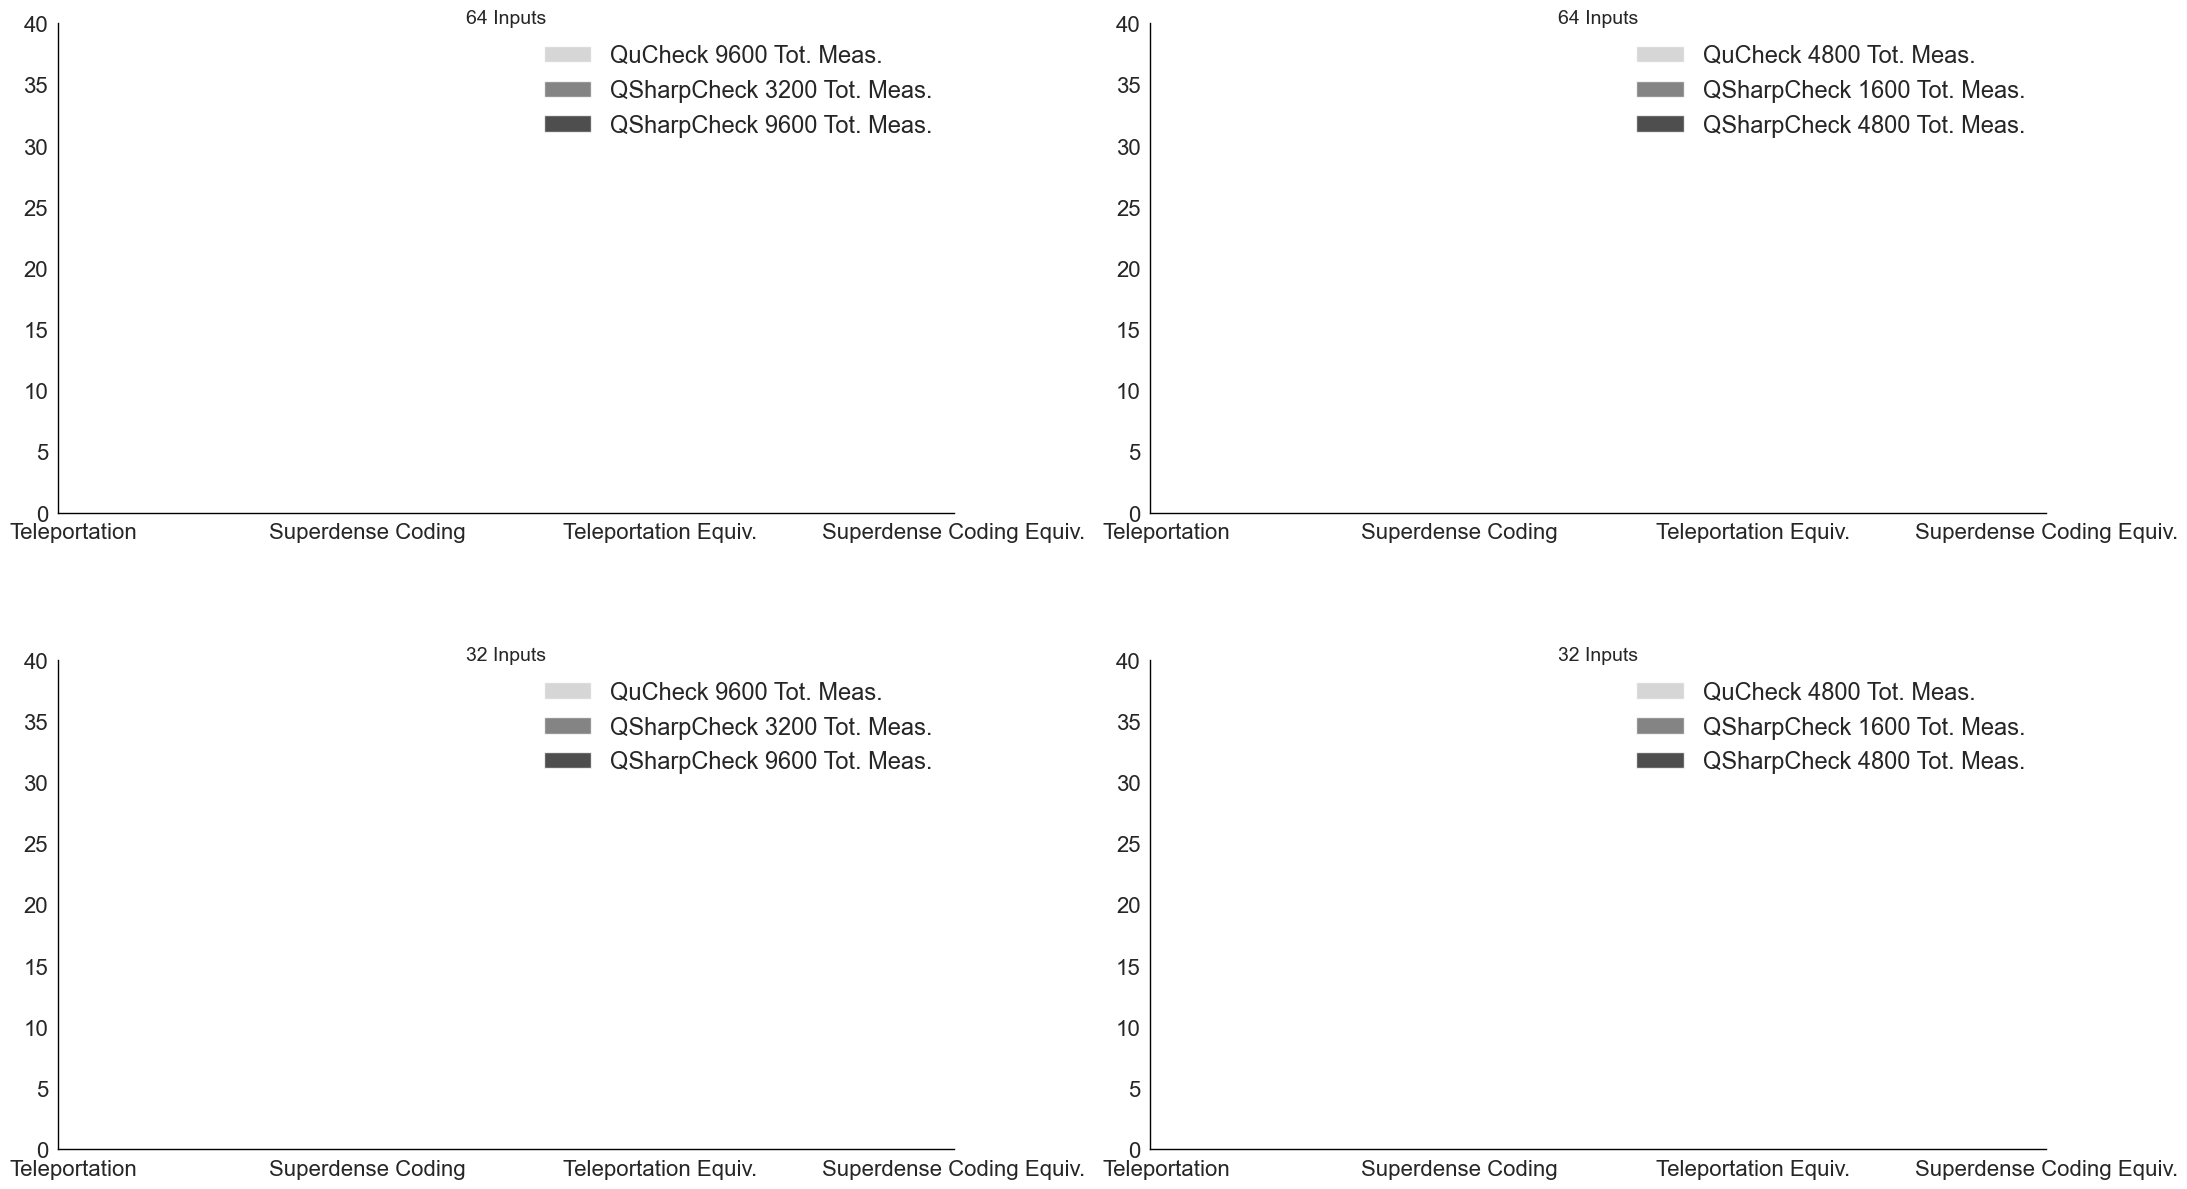

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_quantitative_analysis_comparison(qs_qt_df, qt_df, qs_sd_df, sd_df):
    # Define configurations
    configs = [
        {'measurements': 3200, 'inputs': 64},
        {'measurements': 1600, 'inputs': 64},
        {'measurements': 3200, 'inputs': 32},
        {'measurements': 1600, 'inputs': 32}
    ]

    fig, axes = plt.subplots(2, 2, figsize=(22, 12))
    # fig.suptitle('Comparison of Q# and Qiskit mutation testing of quantum teleportation', fontsize=16)

    for idx, config in enumerate(configs):
        ax = axes[idx // 2, idx % 2]

        # Filter data for the current configuration
        qs_qt_df_filtered = qs_qt_df[
            (qs_qt_df['Number of Measurements'] == config['measurements']) &
            (qs_qt_df['Number of Inputs'] == config['inputs'])
        ]

        qs_qt_df_long_filtered = qs_qt_df[
            (qs_qt_df['Number of Measurements'] == (config['measurements']*3)) &
            (qs_qt_df['Number of Inputs'] == config['inputs'])
        ]

        # Filter data for the current configuration
        qt_df_filtered = qt_df[
            (qt_df['Number of Measurements'] == config['measurements']) &
            (qt_df['Number of Inputs'] == config['inputs'])
        ]

        qs_sd_df_filtered = qs_sd_df[
            (qs_sd_df['Number of Measurements'] == config['measurements']) &
            (qs_sd_df['Number of Inputs'] == config['inputs'])
        ]

        qs_sd_df_long_filtered = qs_sd_df[
            (qs_sd_df['Number of Measurements'] == (config['measurements']*3)) &
            (qs_sd_df['Number of Inputs'] == config['inputs'])
        ]

        sd_df_filtered = sd_df[
            (sd_df['Number of Measurements'] == config['measurements']) &
            (sd_df['Number of Inputs'] == config['inputs'])
        ]


        # Q# results (assumed to be the same for all configurations)
        qs_qt_df_non_equivalent = qs_qt_df_filtered[qs_qt_df_filtered['Mutant Name'].str.contains('_m')]
        qs_non_equiv_failures = qs_qt_df_non_equivalent["Time Taken"].mean()
        qs_non_equiv_failures_compile = qs_qt_df_non_equivalent["Compile Time"].mean()

        qs_sd_df_non_equivalent = qs_sd_df_filtered[qs_sd_df_filtered['Mutant Name'].str.contains('_m')]
        qs_sd_non_equiv_failures = qs_sd_df_non_equivalent["Time Taken"].mean()
        qs_sd_non_equiv_failures_compile = qs_sd_df_non_equivalent["Compile Time"].mean()

        qs_qt_df_equivalent = qs_qt_df_filtered[qs_qt_df_filtered['Mutant Name'].str.contains('_em')]
        qs_equiv_failures = qs_qt_df_equivalent["Time Taken"].mean()
        qs_equiv_failures_compile = qs_qt_df_equivalent["Compile Time"].mean()

        qs_sd_df_equivalent = qs_sd_df_filtered[qs_sd_df_filtered['Mutant Name'].str.contains('_em')]
        qs_sd_equiv_failures = qs_sd_df_equivalent["Time Taken"].mean()
        qs_sd_equiv_failures_compile = qs_sd_df_equivalent["Compile Time"].mean()

        # Q# long results (assumed to be the same for all configurations)
        qs_qt_df_non_equivalent_long = qs_qt_df_long_filtered[qs_qt_df_long_filtered['Mutant Name'].str.contains('_m')]
        qs_non_equiv_failures_long = qs_qt_df_non_equivalent_long["Time Taken"].mean()
        qs_non_equiv_failures_compile_long = qs_qt_df_non_equivalent_long["Compile Time"].mean()

        qs_sd_df_non_equivalent_long = qs_sd_df_long_filtered[qs_sd_df_long_filtered['Mutant Name'].str.contains('_m')]
        qs_sd_non_equiv_failures_long = qs_sd_df_non_equivalent_long["Time Taken"].mean()
        qs_sd_non_equiv_failures_compile_long = qs_sd_df_non_equivalent_long["Compile Time"].mean()

        qs_qt_df_equivalent_long = qs_qt_df_long_filtered[qs_qt_df_long_filtered['Mutant Name'].str.contains('_em')]
        qs_equiv_failures_long = qs_qt_df_equivalent_long["Time Taken"].mean()
        qs_equiv_failures_compile_long = qs_qt_df_equivalent_long["Compile Time"].mean()

        qs_sd_df_equivalent_long = qs_sd_df_long_filtered[qs_sd_df_long_filtered['Mutant Name'].str.contains('_em')]
        qs_sd_equiv_failures_long = qs_sd_df_equivalent_long["Time Taken"].mean()
        qs_sd_equiv_failures_compile_long = qs_sd_df_equivalent_long["Compile Time"].mean()

        # Qiskit results
        qt_df_non_equivalent = qt_df_filtered[qt_df_filtered['Mutant Name'].str.contains('_m')]
        qt_non_equiv_failures = qt_df_non_equivalent["Time Taken"].mean()

        sd_df_non_equivalent = sd_df_filtered[sd_df_filtered['Mutant Name'].str.contains('_m')]
        sd_non_equiv_failures = sd_df_non_equivalent["Time Taken"].mean()

        qt_df_equivalent = qt_df_filtered[qt_df_filtered['Mutant Name'].str.contains('_em')]
        qt_equiv_failures = qt_df_equivalent["Time Taken"].mean()

        sd_df_equivalent = sd_df_filtered[sd_df_filtered['Mutant Name'].str.contains('_em')]
        sd_equiv_failures = sd_df_equivalent["Time Taken"].mean()

        algorithms = ["Teleportation", "Superdense Coding", "Teleportation Equiv.", "Superdense Coding Equiv."]
        qiskit_results = np.array([qt_non_equiv_failures, sd_non_equiv_failures, qt_equiv_failures, sd_equiv_failures])
        qs_results = np.array([qs_non_equiv_failures, qs_sd_non_equiv_failures, qs_equiv_failures, qs_sd_equiv_failures])
        qs_results_compile = np.array([qs_non_equiv_failures_compile, qs_sd_non_equiv_failures_compile, qs_equiv_failures_compile, qs_sd_equiv_failures_compile])
        qs_results_long = np.array([qs_non_equiv_failures_long, qs_sd_non_equiv_failures_long, qs_equiv_failures_long, qs_sd_equiv_failures_long])
        qs_results_compile_long = np.array([qs_non_equiv_failures_compile_long, qs_sd_non_equiv_failures_compile_long, qs_equiv_failures_compile_long, qs_sd_equiv_failures_compile_long])


        # Create the plot
        x = np.arange(len(algorithms))
        width = 0.25

        grays = ["#CCCCCC", "#666666", "#222222"]

        rects1 = ax.bar(
            x - width, qiskit_results, width, color=grays[0],
            label=f'QuCheck {config["measurements"]*3} Tot. Meas.', alpha=0.8
        )

        # Plot compile time bars stacked on top of runtime bars
        rects4 = ax.bar(
            x, qs_results_compile, width, color=grays[1], alpha=0.8,
            bottom=qs_results
        )

        rects2 = ax.bar(
            x, qs_results, width, color=grays[1],
            label=f'QSharpCheck {config["measurements"]} Tot. Meas.', alpha=0.8
        )

        rects5 = ax.bar(
            x + width, qs_results_compile_long, width, color=grays[2], alpha=0.8,
            bottom=qs_results_long
        )

        rects3 = ax.bar(
            x + width, qs_results_long, width, color=grays[2],
            label=f'QSharpCheck {config["measurements"]*3} Tot. Meas.', alpha=0.8
        )

        ax.set_title(f'{config["inputs"]} Inputs', fontsize=14, pad=0)
        # ax.set_title(f'{config["inputs"]} Inputs', fontsize=14, pad=25)
        ax.set_xticks(x)
        ax.set_xticklabels(algorithms)

        ax.bar_label(rects1, padding=3, fontsize=16, labels=[f"{x:.2f}" for x in qiskit_results])
        ax.bar_label(rects2, padding=3, fontsize=16, color='white', labels=[f"{x:.2f}" for x in qs_results])
        ax.bar_label(rects3, padding=3, fontsize=16, color='white', labels=[f"{x:.2f}" for x in qs_results_long])
        ax.bar_label(rects4, padding=3, fontsize=16, labels=[f"{x:.2f}" for x in qs_results_compile])
        ax.bar_label(rects5, padding=3, fontsize=16, labels=[f"{x:.2f}" for x in qs_results_compile_long])

        for item in ax.get_xticklabels() + ax.get_xticklabels() + ax.get_yticklabels() + ax.get_yticklabels():
            item.set_fontsize(16)

        ax.set(ylabel=None)
        ax.spines['left'].set_linewidth(1)
        ax.spines['left'].set_color('k')
        ax.spines['bottom'].set_linewidth(1)
        ax.spines['bottom'].set_color('k')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.legend(frameon=False, fontsize=17)


        ax.set_ylim(0, 40.01)
        ax.grid(False)

    plt.tight_layout()
    fig.subplots_adjust(hspace=0.3)
    # plt.savefig(f"quantitative_comparison_time.png", dpi=100, bbox_inches='tight')
    plt.savefig(f"quantitative_comparison_time.png", dpi=300, bbox_inches='tight')
    plt.show()
    # plt.show()

# To use this function, uncomment the following lines and run the script:
df1 = pd.read_csv(f"mutation_test_results/quantum_teleportation/QTQS_in_out.csv")
df2 = pd.read_csv(f"mutation_test_results/quantum_teleportation/quantum_teleportation_in_out_eq_merged_results.csv")
df3 = pd.read_csv(f"mutation_test_results/superdense_coding/SDQS_correct_bits.csv")
df4 = pd.read_csv(f"mutation_test_results/superdense_coding/superdense_coding_correct_bits_merged_results.csv")
plot_quantitative_analysis_comparison(df1, df2, df3, df4)

In [38]:
def split_and_group_dfs(dfs):
    grp_and_split_dfs = []
    for algorithm_df in dfs:
        df_non_equivalent = algorithm_df[algorithm_df['Mutant Name'].str.contains('_m')]
        df_equivalent = algorithm_df[algorithm_df['Mutant Name'].str.contains('_em')]

        failure_rate = \
        df_non_equivalent.groupby(["Number of Measurements", "Number of Inputs", "Number of Properties"])[
            'Result'].apply(lambda x: (x == 'Fail').sum()).reset_index(name='Result')
        pass_rate = df_equivalent.groupby(["Number of Measurements", "Number of Inputs", "Number of Properties"])[
            'Result'].apply(lambda x: (x == 'Fail').sum()).reset_index(name='Result')

        grp_and_split_dfs.append((failure_rate, pass_rate))
    return grp_and_split_dfs

dfs_names = ["Quantum Teleportation", "Deutsch-Jozsa", "Quantum Fourier Transform", "Quantum Phase Estimation", "Grover's Algorithm"]
dfs = [qt_df, dj_df, qft_df, qpe_df, grover_df]
split_grouped_dfs = split_and_group_dfs(dfs)

def get_stats_(df, group_by="Number of Properties", filter_by_feature=None, filter_by_values=None):
    failure_rate = df[df['Equivalent'] == False]
    pass_rate = df[df['Equivalent'] == True]

    if filter_by_feature is not None:
        for i in range(len(filter_by_feature)):
            failure_rate = failure_rate[failure_rate[filter_by_feature[i]].isin(filter_by_values[i])]
            pass_rate = pass_rate[pass_rate[filter_by_feature[i]].isin(filter_by_values[i])]

    print("Not Equivalent")

    if group_by is not None:
        print("STD NE")
        print(failure_rate.groupby(group_by)['Result'].std())
        print("Median NE")
        print(failure_rate.groupby(group_by)['Result'].median())
        print("Mean NE")
        print(failure_rate.groupby(group_by)['Result'].mean())
        print("Pearson Correlation Coefficient NE")
        print(scipy.stats.spearmanr(failure_rate[group_by], failure_rate["Result"], alternative='two-sided'))
    else:
        print("STD NE")
        print(failure_rate['Result'].std())
        print("Median NE")
        print(failure_rate['Result'].median())
        print("Mean NE")
        print(failure_rate['Result'].mean())

    print("Equivalent")

    if group_by is not None:
        print("STD E")
        print(pass_rate.groupby(group_by)['Result'].std())
        print("Median E")
        print(pass_rate.groupby(group_by)['Result'].median())
        print("Mean E")
        print(pass_rate.groupby(group_by)['Result'].mean())
        print("Pearson Correlation Coefficient E")
        print(scipy.stats.spearmanr(pass_rate[group_by], pass_rate["Result"], alternative='two-sided'))
    else:
        print("STD E")
        print(pass_rate['Result'].std())
        print("Median E")
        print(pass_rate['Result'].median())
        print("Mean E")
        print(pass_rate['Result'].mean())

def clean_and_add_time(dfs_list):
    for df in dfs_list:
        df["Equivalent"] = df['Mutant Name'].str.contains('_em')
        df["Algorithm"] = df.apply(lambda x: x['Mutant Name'][:-4] if x['Equivalent'] else x['Mutant Name'][:-3], axis=1)
        return df

In [39]:
all_df_c = clean_and_add_time([all_df])

df1 = pd.read_csv(f"mutation_test_results/quantum_teleportation/QTQS_in_out.csv")
df2 = pd.read_csv(f"mutation_test_results/superdense_coding/SDQS_correct_bits.csv")
qsharp = pd.concat([df1, df2])
df1 = pd.read_csv(f"mutation_test_results/quantum_teleportation/quantum_teleportation_in_out_eq_merged_results.csv")
df2 = pd.read_csv(f"mutation_test_results/superdense_coding/superdense_coding_correct_bits_merged_results.csv")
qcheck = pd.concat([df1, df2])

In [40]:
qsharp = clean_and_add_time([qsharp])
get_stats(qsharp, group_by='Number of Measurements', filter_by_feature=['Number of Measurements', 'Number of Inputs'], filter_by_values=[[12600, 7500], [100]], feature_str="Time Taken")

Not Equivalent
STD NE
Number of Measurements
7500     15.637334
12600    25.480407
Name: Time Taken, dtype: float64
Median NE
Number of Measurements
7500     0.953
12600    0.744
Name: Time Taken, dtype: float64
Mean NE
Number of Measurements
7500     14.081450
12600    20.678325
Name: Time Taken, dtype: float64
Pearson Correlation Coefficient NE
SignificanceResult(statistic=0.14731958926138727, pvalue=0.19221432643683065)
Equivalent
STD E
Number of Measurements
7500      7.035123
12600    10.098782
Name: Time Taken, dtype: float64
Median E
Number of Measurements
7500     32.4800
12600    55.8415
Name: Time Taken, dtype: float64
Mean E
Number of Measurements
7500     31.63115
12600    54.18430
Name: Time Taken, dtype: float64
Pearson Correlation Coefficient E
SignificanceResult(statistic=0.8489702403754517, pvalue=4.467258222809812e-12)


In [44]:
Mean_NE_QS = (14.081450 + 20.678325)/2
print(Mean_NE_QS)
Mean_E_QS = (31.63115 + 54.18430)/2
print(Mean_E_QS)
Mean_NE_Qu = (5.196225 + 6.122075)/2
print(Mean_NE_Qu)
Mean_E_Qu = (3.32445 + 4.12560)/2
print(Mean_E_Qu)

NE_percent_decrease = ((Mean_NE_QS - Mean_NE_Qu) / Mean_NE_QS) * 100
print(NE_percent_decrease)
E_percent_decrease = ((Mean_E_QS - Mean_E_Qu) / Mean_E_QS) * 100
print(E_percent_decrease)

QS_mean = (Mean_NE_QS + Mean_E_QS) / 2
Qu_mean = (Mean_NE_Qu + Mean_E_Qu) / 2
Qu_QS_percent_decrease = ((QS_mean - Qu_mean) / QS_mean) * 100
print(Qu_QS_percent_decrease)

17.379887500000002
42.907725
5.65915
3.7250250000000005
67.43851190060926
91.31852131521771
84.43432305434222


In [43]:
qcheck = clean_and_add_time([qcheck])
get_stats(qcheck, group_by='Number of Measurements', filter_by_feature=['Number of Measurements', 'Number of Inputs'], filter_by_values=[[4200, 2500], [100]], feature_str="Time Taken")

Not Equivalent
STD NE
Number of Measurements
2500    1.298788
4200    1.875581
Name: Time Taken, dtype: float64
Median NE
Number of Measurements
2500    4.9100
4200    5.2775
Name: Time Taken, dtype: float64
Mean NE
Number of Measurements
2500    5.196225
4200    6.122075
Name: Time Taken, dtype: float64
Pearson Correlation Coefficient NE
SignificanceResult(statistic=0.33128059925543174, pvalue=0.0026849480278558786)
Equivalent
STD E
Number of Measurements
2500    0.715069
4200    1.258674
Name: Time Taken, dtype: float64
Median E
Number of Measurements
2500    3.2585
4200    4.0100
Name: Time Taken, dtype: float64
Mean E
Number of Measurements
2500    3.32445
4200    4.12560
Name: Time Taken, dtype: float64
Pearson Correlation Coefficient E
SignificanceResult(statistic=0.39853362292533, pvalue=0.01086151440005562)
